This script will
- Get data from stations
- Get processed altimeter data
- Plot data location
- Plot time series altimeter and station
- Calculate and Plot accuracies
- Separate low level from high levels

In [24]:
from ground_data import GroundObservations
import geopandas as gpd
import platform
from ts_preprocesing import *#get_date_time_cols
import scipy.interpolate as sc
import geopandas as gpd
from timezonefinder import TimezoneFinder
from icecream import ic
# from ts_preprocesing import convert_units
import importlib
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pytz
from pytz import timezone
import timeit
from datetime import datetime
utc=pytz.utc
utc.zone
%reload_ext autoreload
%autoreload 2

#Test Getting data from stations
#So far what works
# Getting locss stations

In [25]:
#Test Getting data from stations
#So far what works
# Getting locss stations

go=GroundObservations()
height_fd='height'

lc_lakes=['KHB2','HMT2','PHN2','SAW2','BTN2','QUL2', 'WEW2', 'CFN2','YSL2','SLL2','TAB2','MAB2', 'CQK2', 'SKT2', 'MCW2', 'PAW2', 'MRP2', 'SPA2', 'BLB2','RLH2','MTN2']
# lc_lakes=['CQK2']
df_locss=go.read_ground_data('LOCSS', station_id=lc_lakes)
df_locss=get_date_time_cols(df_locss, 'date', has_hour=True)
stations=df_locss['gauge_id'].unique()
df_final=convert_units(df_locss,height_fd, origin='FEET', to='METER', unit_fd='unit',
                  gauge_fd='gauge_id')

#Extract gauges that are not operational less than 2 data
lk_id_fd='gauge_id'

df_readings_count=df_final.groupby([lk_id_fd], as_index=False).size()
no_operational_gauges=df_readings_count.loc[df_readings_count['size']<=2][lk_id_fd]

print('Initial size',df_final.shape)
df_final=df_final.loc[~df_final[lk_id_fd].isin(no_operational_gauges)]
print('Final size',df_final.shape)

#0. Sort by date at each station. Calculate the differences between consecutive values and dates
#Remove and process duplicate dates
cut_off=0.05

gauges_list=lc_lakes#df_final[st_id].unique()

date_fd='date'
cols=['gauge_id', 'name', 'date', 'time', 
       'min_height', 'max_height', 'unit', 'source',
       'year', 'month', 'day', 'hour', 'decimal_y']

         
df_final_nd=filter_extreme_duplicates(df_final, lk_id_fd, date_fd,height_fd, cols, cut_off, gauge_list=gauges_list)
df_final_nd.rename(columns={'height_rc':height_fd}, inplace=True)
#Extract the ones with duplicates from df_final

df_temp=df_final.loc[~df_final[lk_id_fd].isin(df_final_nd[lk_id_fd].unique())]
df_temp=pd.concat((df_temp, df_final_nd), axis=0)

#TODO----KEEP IN MIND THAT SOME ATTRIBUTES WON'T BE COPY TO THE FINAL DATAFRAME

Initial size (3679, 18)
Final size (3677, 18)


Getting ARHN stations 
Getting USGS stations from file. Still working on R script connection
Getting Brazilian Reservoirs

In [26]:
# Getting ARHN stations 
# Getting USGS stations from file. Still working on R script connection
# Getting Brazilian Reservoirs
# #'2102' Is a meteorlogical station 

ar_lakes=['1824', '2830', '1830','2832', '2028','2231','2234','2300','2316']#'1805', '1819',
skip_rows=1

df_arhn=go.read_ground_data('ARHN', skip_rows=skip_rows, station_id=ar_lakes)
df_arhn=get_date_time_cols(df_arhn, 'date', has_hour=True)

us_lakes=['2464800','6903880','6604000']
df_usgs=go.read_ground_data('USGS',station_id=us_lakes)
df_usgs=get_date_time_cols(df_usgs, 'date')
df_usgs=convert_units(df_usgs,height_fd, origin='FEET', to='METER', 
                  gauge_fd='gauge_id')
# # df_usgs.height.hist()
# # df_usgs.height_rw.hist()#head()
rvbr_lakes=['19069','19060','19126', '12030', '12036', '12327','12056']
df_rvbr=go.read_ground_data('RVBR', station_id=rvbr_lakes)
df_rvbr=get_date_time_cols(df_rvbr,'date')

# #falta Brazil
# df['file_name'].str.split('_', expand=True)

Concat all the ground time series

In [27]:
#Relevant columns
# df_ground_ts=pd.DataFrame()
common_cols=['gauge_id','source','decimal_y','height','date','year', 'month', 'day', 'hour']
# df_usgs[common_cols]
df_ground_ts=pd.concat((df_usgs[common_cols].copy(),df_arhn[common_cols].copy(), df_temp[common_cols].copy(), df_rvbr[common_cols].copy()), axis=0)

#Focus on LOCSS
# df_ground_ts=df_temp[common_cols].copy()
# df_ground_ts=df_final.copy()
df_ground_ts.shape
# pd.datetime(+pd.to_datetime(df_final['time'], format='%H:%M:%S'), format='%Y-%m-%d %H:%M:%S')
# df_ground_ts.columns

(362484, 9)

Get selected lakes

In [28]:
#Get selected lakes 
if platform.system()=='Linux':
    path_lakes='/home/angelica/Dropbox/Research/LOCSS/other_lakes/Selected_lakes/all_lakes_wgs84_f.shp'
else:
    path_lakes='C:/Users/amgomez/Dropbox/Research/LOCSS/other_lakes/Selected_lakes/all_lakes_wgs84_f.shp'

df_sel_lakes=gpd.read_file(path_lakes)



In [29]:
#Add the ice covered from Xiao's code

df_ice=pd.read_csv('../data/locss_ice.csv')
df_ice

#If data if taken in other computer you can use data_preprocessed.csv

# df_ground_ts.to_csv('../data/results/data_preprocessed.csv', sep=',')
# df_ground_ts=pd.read_csv('../data/results/data_preprocessed.csv', sep=',', low_memory=False, parse_dates=['date'])
##Option 1..To Slow
# df_ground_ts['doy']=[pd.Period(x, freq='D').dayofyear for x in df_ground_ts['date']]
# df_ground_ts['doy']

#Option 2 if date is datetime 
df_ground_ts['doy']=df_ground_ts['date'].dt.dayofyear

df_ice=pd.merge(df_ice, df_sel_lakes[['Hylak_id', 'gauge_id']], on='Hylak_id', how='left')
df_ground_ts=pd.merge(df_ground_ts, df_ice[['Hylak_id', 'gauge_id','SLIDE_snowIce','doy']], on=['gauge_id','doy'], how='left')

#merge name based on gauge_id
df_lake_name=df_sel_lakes[['gauge_id','lake_name']]
df_ground_ts=pd.merge(df_ground_ts, df_lake_name, on='gauge_id',how='left')

In [30]:
df_ground_ts.loc[df_ground_ts['gauge_id']=='PHN2']

,gauge_id,source,decimal_y,height,date,year,month,day,hour,doy,Hylak_id,SLIDE_snowIce,lake_name
339660,PHN2,LOCSS,2018.489155,3.398520,2018-06-28 13:17:00,2018,6,28,13,179,9340.0,0.013407,Lake Phelps
339661,PHN2,LOCSS,2018.489155,3.398520,2018-06-28 13:17:00,2018,6,28,13,179,9340.0,0.000091,Lake Phelps
339662,PHN2,LOCSS,2018.609132,3.468624,2018-08-11 08:12:22,2018,8,11,8,223,NaN,NaN,Lake Phelps
339663,PHN2,LOCSS,2018.645320,3.508248,2018-08-24 13:02:44,2018,8,24,13,236,9340.0,0.001295,Lake Phelps
339664,PHN2,LOCSS,2018.000000,3.230880,2018-01-01 00:01:00,2018,1,1,0,1,NaN,NaN,Lake Phelps
...,...,...,...,...,...,...,...,...,...,...,...,...,...
339957,PHN2,LOCSS,2022.018151,3.371088,2022-01-07 15:05:03,2022,1,7,15,7,NaN,NaN,Lake Phelps
339958,PHN2,LOCSS,2022.100000,3.364992,2022-02-06 12:24:05,2022,2,6,12,37,NaN,NaN,Lake Phelps
339959,PHN2,LOCSS,2022.220320,3.352800,2022-03-22 10:43:31,2022,3,22,10,81,9340.0,0.000003,Lake Phelps
339960,PHN2,LOCSS,2022.253311,3.535680,2022-04-03 11:35:01,2022,4,3,11,93,9340.0,0.000000,Lake Phelps


In [35]:
# df_ground_ts.loc[df_ground_ts['gauge_id']=='RLH2']

In [31]:
vals=['AUB2', 'BAB2', 'BAN2', 'BJB2', 'BOB2', 'CBB2', 'DRB2', 'DTB2',
       'DUB2', 'GAB2', 'HHB2', 'HKB2', 'HLB2', 'JNN2', 'KPB2', 'MEB2',
       'NBB2', 'NHB2', 'NPH2', 'PGH2', 'PLH2', 'PYB2', 'RRV2', 'SAN2',
       'SKB2', 'TAB2', 'TLB2', 'UBB2']
df_ground_ts.loc[df_ground_ts['gauge_id'].isin(vals), 'gauge_id'].unique()

array(['TAB2'], dtype=object)

In [7]:
df_ground_ts['gauge_id'].unique()


array(['2464800', '6903880', '6604000', '1824', '2830', '1830', '2832',
       '2028', '2231', '2234', '2300', '2316', 'BLB2', 'BTN2', 'CFN2',
       'HMT2', 'KHB2', 'MAB2', 'MCW2', 'MRP2', 'MTN2', 'PAW2', 'PHN2',
       'QUL2', 'RLH2', 'SAW2', 'SLL2', 'SPA2', 'WEW2', 'YSL2', 'TAB2',
       '19069', '19060', '19126', '12030', '12036', '12327', '12056'],
      dtype=object)

set manually Bangladesh lakes


In [32]:
df_ground_ts_org=df_ground_ts.copy()

In [33]:
def extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim):
    df_ground_ex=df.loc[df[st_id_fd]==st_id].copy()
    df_ground_re=df.loc[~(df[st_id_fd]==st_id)].copy()
    df_ground_ex=df_ground_ex.sort_values(by=[date_fd])
    df_ground_ex['diff']=df_ground_ex[height_fd].diff()
    # df_ground_ex['diff'].max()
    df_diff_to_remove=df_ground_ex.loc[((df_ground_ex['diff']>=high_lim)|(df_ground_ex['diff']<=low_lim))]
    return (df_ground_ex, df_ground_re, df_diff_to_remove)
    #df with only the station st_id, df without station st_id, df with df to remove



def remove_extreme_data(df,df_diff_to_remove, date_fd, height_fd, diff_fd):
    df=df.copy()
    row_iterator = df_diff_to_remove.iterrows()
    _, this = next(row_iterator)  # take first item from row_iterator
    for index,next_to in row_iterator:
        current_date=this[date_fd]
        next_date=next_to[date_fd]
        diff_replace=df.loc[df[date_fd]==current_date,diff_fd]
        mask=(df[date_fd]>=current_date)&(df[date_fd]<next_date)
        hg=df.loc[mask,height_fd]
        df.loc[mask,height_fd]=hg-np.round(diff_replace.iloc[0],decimals=2)
        df[diff_fd]=df[height_fd].diff()
        new_diff=np.round(df.loc[df[date_fd]==next_date,diff_fd],decimals=2)
        next_to[diff_fd]=new_diff
        this=next_to

    current_date=next_to[date_fd]
    next_date=df[date_fd].max()
    diff_replace=df.loc[df[date_fd]==current_date,diff_fd]
    # print(diff_replace.values)
    mask=(df[date_fd]>=current_date)&(df[date_fd]<=next_date)
    hg=df.loc[mask,height_fd]
    df.loc[mask,height_fd]=hg-np.round(diff_replace.iloc[0],decimals=2)
    df[diff_fd]=df[height_fd].diff()
    return df


In [34]:
df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='KHB2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.5
high_lim=.5

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

date_fd='date'
diff_fd='diff'
df_ground_fixed=remove_extreme_data(df_ground_ex,df_diff_to_remove, date_fd, height_fd, diff_fd)
df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

In [14]:
df_diff_to_remove

,gauge_id,source,decimal_y,height,date,year,month,day,hour,lake_name,doy,Hylak_id,SLIDE_snowIce,diff
338617,KHB2,LOCSS,2021.507877,0.41,2021-07-05 09:00:00,2021,7,5,9,Khajura Baor,186,NaN,NaN,-2.03
338721,KHB2,LOCSS,2021.669521,2.26,2021-09-02 09:00:00,2021,9,2,9,Khajura Baor,245,NaN,NaN,1.53
338747,KHB2,LOCSS,2021.707877,3.77,2021-09-16 09:00:00,2021,9,16,9,Khajura Baor,259,NaN,NaN,1.39
338755,KHB2,LOCSS,2021.718836,2.56,2021-09-20 09:00:00,2021,9,20,9,Khajura Baor,263,NaN,NaN,-1.17
338895,KHB2,LOCSS,2021.910616,3.61,2021-11-29 09:00:00,2021,11,29,9,Khajura Baor,333,NaN,NaN,1.81


In [35]:
df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='TAB2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.5
high_lim=.5

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

date_fd='date'
diff_fd='diff'
df_ground_fixed=remove_extreme_data(df_ground_ex,df_diff_to_remove, date_fd, height_fd, diff_fd)
df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

In [71]:
df_diff_to_remove

,Unnamed: 0,gauge_id,source,decimal_y,height,date,year,month,day,hour,lake_name,doy,Hylak_id,SLIDE_snowIce,diff
341466,332063,TAB2,LOCSS,2021.491438,5.42,2021-06-29 09:00:00,2021,6,29,9,Tanguar Haor,180,NaN,NaN,-0.86
341666,332263,TAB2,LOCSS,2021.776370,4.91,2021-10-11 09:00:00,2021,10,11,9,Tanguar Haor,284,NaN,NaN,0.94
341680,332277,TAB2,LOCSS,2021.795548,5.76,2021-10-18 09:00:00,2021,10,18,9,Tanguar Haor,291,NaN,NaN,1.11
341686,332283,TAB2,LOCSS,2021.803767,4.91,2021-10-21 09:00:00,2021,10,21,9,Tanguar Haor,294,NaN,NaN,-0.81
341690,332287,TAB2,LOCSS,2021.809247,5.86,2021-10-23 09:00:00,2021,10,23,9,Tanguar Haor,296,NaN,NaN,0.99


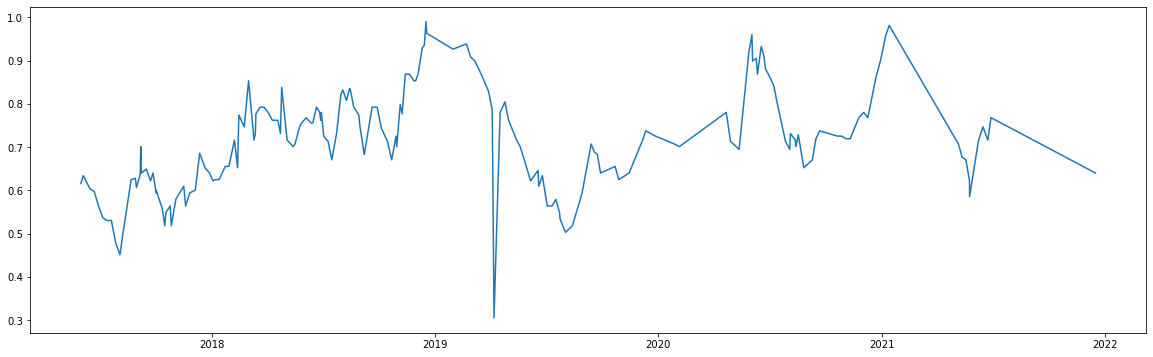

In [36]:
df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='MTN2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.4
high_lim=.4
df1=df.loc[df[st_id_fd]==st_id]
df1=df1.sort_values(by=date_fd)
plt.figure(figsize=(20, 6))
plt.plot(df1[date_fd], df1[height_fd])

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

In [37]:
df_ground_fixed=df_ground_ex.loc[df_ground_ex['date']!='2019-04-07 14:55:00']
df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

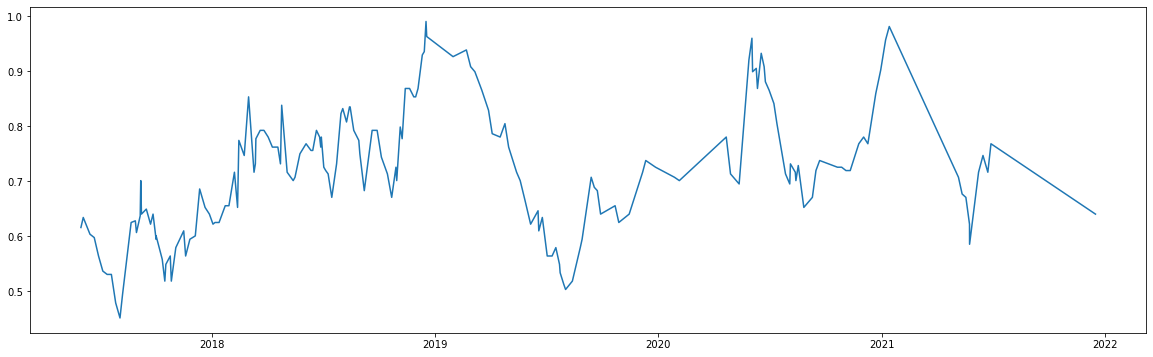

In [38]:
#plot again
st_id='MTN2'
df1=df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id]
df1=df1.sort_values(by=date_fd)
plt.figure(figsize=(20, 6))
plt.plot(df1[date_fd], df1[height_fd])


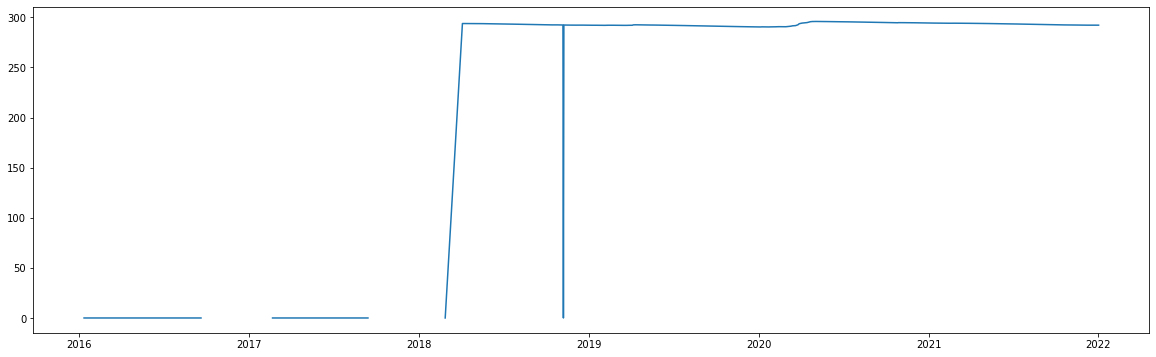

In [39]:
st_id='12327'
df1=df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id]
df1=df1.sort_values(by=date_fd)
plt.figure(figsize=(20, 6))
plt.plot(df1[date_fd], df1[height_fd])

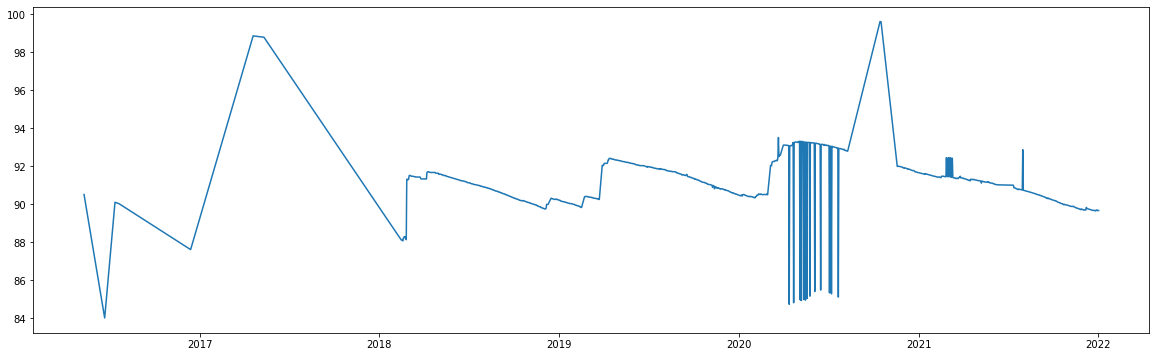

In [40]:
st_id='12056'
df1=df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id]
df1=df1.sort_values(by=date_fd)
plt.figure(figsize=(20, 6))
plt.plot(df1[date_fd], df1[height_fd])
low_lim=-5
high_lim=5
df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df1, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

In [77]:
df_diff_to_remove

,Unnamed: 0,gauge_id,source,decimal_y,height,date,year,month,day,hour,lake_name,doy,Hylak_id,SLIDE_snowIce,diff
370706,361303,12056,RVBR,2016.471311,84.00,2016-06-21,2016,6,21,12,Açude Boa Vista,173,NaN,NaN,-6.50
370707,361304,12056,RVBR,2016.528689,90.09,2016-07-12,2016,7,12,12,Açude Boa Vista,194,NaN,NaN,6.09
370710,361307,12056,RVBR,2017.297260,98.85,2017-04-19,2017,4,19,12,Açude Boa Vista,109,NaN,NaN,11.25
370712,361309,12056,RVBR,2018.121918,88.10,2018-02-14,2018,2,14,12,Açude Boa Vista,45,NaN,NaN,-10.68
371403,362000,12056,RVBR,2020.280055,84.72,2020-04-12,2020,4,12,12,Açude Boa Vista,103,NaN,NaN,-8.36
371404,362001,12056,RVBR,2020.282787,93.04,2020-04-13,2020,4,13,12,Açude Boa Vista,104,NaN,NaN,8.32
371412,362009,12056,RVBR,2020.304645,84.80,2020-04-21,2020,4,21,12,Açude Boa Vista,112,NaN,NaN,-8.44
371413,362010,12056,RVBR,2020.307377,93.24,2020-04-22,2020,4,22,12,Açude Boa Vista,113,NaN,NaN,8.44
371425,362022,12056,RVBR,2020.340164,84.96,2020-05-04,2020,5,4,12,Açude Boa Vista,125,NaN,NaN,-8.34
371427,362024,12056,RVBR,2020.342896,93.30,2020-05-05,2020,5,5,12,Açude Boa Vista,126,NaN,NaN,8.34


In [24]:
#To save and prevent problem of reading from windows
# df_ground_ts.to_csv('../data/results/data_preprocessed.csv', sep=',')

In [41]:
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter
#Plots
#Plot deviation of the mean from satellite, groound observations and interpolated points
def plot_dev_mean(nfig,dfs, dfg, dfi, source, st_id, altis_name, date_fd, height_fd, labels, labelg, labeli, error_m_text=None, output_f=None):
    plt.figure(nfig, figsize=(20, 6))
    splot=plt.plot(dfs[date_fd], 
                   dfs[height_fd]-np.nanmean(dfs[height_fd]), linestyle='None',marker='o', 
                   markerfacecolor='#20641c',markeredgecolor='#20641c',markersize=5, label=labels)
    gplot=plt.plot(dfg[date_fd], 
                   dfg[height_fd]-dfg[height_fd].mean(), linestyle='solid',
                   markerfacecolor='#0000FF',markeredgecolor='#0000FF',color='#0000FF',marker='o', markersize=2, label=labelg)
    iplot=plt.plot(dfi[date_fd].to_numpy(), 
                   dfi[height_fd]-np.nanmean(dfi[height_fd]), linestyle='None',
                   markerfacecolor='#d95f02', markeredgecolor='#d95f02',marker='s', 
                   markersize=5, label=labeli)
    # plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    ax=plt.gca()
    if error_m_text is not None:
        plt.text(0.01, 0.8, 'Metrics'+error_m_text, fontsize = 15, transform=ax.transAxes)
        
    plt.xlabel('Time (decimal year)', size=15, weight='bold')
    plt.ylabel('Water elev. dev from mean (m)', size=15, weight='bold')
    plt.grid('on')
    plt.legend(loc='upper right')
    plt.title('Deviation from the mean time series comparison', size=15,
              weight='bold')


    if output_f is not None:
        if not os.path.isdir(output_f):
            os.mkdir(output_f) 
        plt.savefig(output_f+source+'_'+st_id+'_vs_'+altis_name+'.png',
                bbox_inches='tight')
    
    plt.show()
    return plt


#Plots
#Plot deviation of the mean from satellite, groound observations and interpolated points
def plot_dev_mean_publish(nfig,dfs, dfg, source, st_id, altis_name, date_fd, height_fd, labels, labelg, fill_between=None, error_m_text=None, output_f=None):
    #plt.figure(nfig, figsize=(20, 6))
    
    if 'Sentinel-3A' in altis_name:
        markerfacecolor='#D81B60'
        markeredgecolor='#D81B60'
        marker='o'
        markersize=5
    elif 'Sentinel-3B' in altis_name:
        markerfacecolor='#000000'
        markeredgecolor='#000000'
        marker='o'
        markersize=5
    else:
        markerfacecolor='#004D40'
        markeredgecolor='#004D40'
        marker='*'
        markersize=8

    #Azul#0000FF
    ax=plt.gca()
    ax.axhline(linewidth=1, color='#575656',linestyle='--')
    
    dfg=dfg.sort_values(by=date_fd)

    #Get the time difference in minutes between each data point and extract the median
    temp_diff=dfg[date_fd].diff().apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')
    mean_diff_time=temp_diff.median()

    #Get the indices in which difference in time between data point is greater than 10 days (14400 min), repeat cycle for Jason 3
    indices = np.where(np.abs(temp_diff.to_numpy()) >= 14400)[0] 

    #Plot only the lines between the intervals of continues measurements
    
    for n, i in enumerate(indices):
        if n == 0:
            plt.plot(dfg[date_fd].to_numpy()[:i], (dfg[height_fd]-dfg[height_fd].mean()).to_numpy()[:i], linestyle='solid',
                    markerfacecolor='#7570b3',markeredgecolor='#7570b3',color='#7570b3',marker='o', markersize=3)#, label=labelg)
        else:
            plt.plot(dfg[date_fd].to_numpy()[indices[n - 1]:i], (dfg[height_fd]-dfg[height_fd].mean()).to_numpy()[indices[n - 1]:i], linestyle='solid',
                    markerfacecolor='#7570b3',markeredgecolor='#7570b3',color='#7570b3',marker='o', markersize=3) #, label=labelg)

    #Plot the last part of the series. If not gaps it plots the complete series
    if len(indices)==0:
        i=0
    
    l_idx=len(temp_diff.to_numpy())
    plt.plot(dfg[date_fd].to_numpy()[i:l_idx], (dfg[height_fd]-dfg[height_fd].mean()).to_numpy()[i:l_idx], linestyle='solid',
                    markerfacecolor='#7570b3',markeredgecolor='#7570b3',color='#7570b3',marker='o', markersize=3) #, label=labelg)
    
    splot=plt.plot(dfs[date_fd], 
                   dfs[height_fd]-np.nanmean(dfs[height_fd]), linestyle='None',marker=marker, 
                   markerfacecolor=markerfacecolor,markeredgecolor=markerfacecolor,markersize=markersize, label=labels)
    
    # if error_m_text is not None:
    #     plt.text(0.01, 0.8, 'Metrics'+error_m_text, fontsize = 8, transform=ax.transAxes)
        
    # plt.xlabel('Time (decimal year)', size=15, weight='bold')
    # plt.ylabel('Water elev. dev from mean (m)', size=15, weight='bold')
    # plt.grid('on')
    plt.grid(color='#808080', linestyle='-.', linewidth=0.5)
    ymin,ymax=plt.ylim()
    if abs(ymin)>abs(ymax):
        ymax=abs(ymin)+0.1
    elif abs(ymin)<abs(ymax):
        ymin=-abs(ymax)-0.1
        
    #If needed fill between 
    if fill_between is not None:
        fb_fill_fd=fill_between['fill']
        if dfg.loc[dfg[fb_fill_fd].notna()].shape[0]!=0:
            lim=fill_between['lim'] #TODO: Generalize this more
            ax.fill_between(dfg[date_fd], ymin, ymax, where=(dfg[fb_fill_fd] > lim), alpha=0.5, color='#C5C5C5')
        
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 1 decimal places    
    plt.ylim(ymin,ymax)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=45, horizontalalignment='right', fontsize=12)
    for ylabel in ax.get_yticklabels(which='major'):
        ylabel.set(fontsize=12)
        
    fig.tight_layout(h_pad=3, w_pad=2)
    # plt.legend(loc='lower right')
    plt.title(labelg+error_m_text, size=14,
              weight='bold')


    if output_f is not None:
        if not os.path.isdir(output_f):
            os.mkdir(output_f) 
        plt.savefig(output_f+source+'_'+st_id+'_vs_'+altis_name+'.png',
                bbox_inches='tight')
    
    return plt

In [42]:
df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()
df_cm=pd.DataFrame()

In [20]:
df_ground_st.head()

,Unnamed: 0,gauge_id,source,decimal_y,height,date,year,month,day,hour,lake_name_x,doy,Hylak_id,SLIDE_snowIce,lake_name_y,diff
28926,22673,1824,ARHN,2000.000797,1.26,2000-01-01 07:00:00,2000,1,1,7,Lago Mascardi,1,NaN,NaN,Lago Mascardi,NaN
28927,22674,1824,ARHN,2000.003529,1.26,2000-01-02 07:00:00,2000,1,2,7,Lago Mascardi,2,NaN,NaN,Lago Mascardi,NaN
28928,22675,1824,ARHN,2000.006261,1.26,2000-01-03 07:00:00,2000,1,3,7,Lago Mascardi,3,10598.0,0.0,Lago Mascardi,NaN
28929,22676,1824,ARHN,2000.008994,1.25,2000-01-04 07:00:00,2000,1,4,7,Lago Mascardi,4,10598.0,0.0,Lago Mascardi,NaN
28930,22677,1824,ARHN,2000.011726,1.23,2000-01-05 07:00:00,2000,1,5,7,Lago Mascardi,5,NaN,NaN,Lago Mascardi,NaN


In [43]:
#Test to determine potential number of figures
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'


if platform.system()=='Linux':
    altis_csv=pd.read_csv(path, sep=',',encoding='iso-8859-1')
else:
    altis_csv=pd.read_csv(path, sep=',', encoding='windows-1252')  


#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'

time_fig=datetime.now().strftime("%Y%m%d_%H_%M")

df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()
    

tf=TimezoneFinder()

#Filter to lakes approved
#---------------------------
approve_locss=df_sel_lakes.loc[df_sel_lakes['AprovedFor']==1]['gauge_id'].values #['HMT2','PHN2','SAW2','BTN2','QUL2', 'WEW2', 'CFN2','YSL2','SLL2','TAB2','KHB2']
altis_csv=altis_csv.loc[altis_csv['station_id'].isin(approve_locss)]

lon_fd='lon'
lat_fd='lat'

df_gts=df_ground_ts.copy()

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999

wse_ref='e'
i=1

#################CHANGE WITH N COMPARISON ####################
#----ALL
this_source='ALL'

#----ARHN
# this_source='ARHN'

##---LOCSS
# this_source='LOCSS'

#---USGS
# this_source='USGS'

##----RVBR
# this_source='RVBR'

#-----ICECV

# this_source='ICECV'
###########################################################

if this_source not in ['ALL', 'ICECV']:
    altis_csv=altis_csv.loc[altis_csv['source']==this_source].copy()

data_source=this_source

altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
#filter only altis time series with ground observations
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]

altis_w_gts_csv=altis_w_gts_csv.sort_values(by='source')

for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    ncolgeoid=row['ncolgeoid']
    # Call every altis relative to the ellipsoide
    
    # is_Sentinel=altis_name.find('Sentinel-3')
    # if is_Sentinel!=-1:
    if ncolgeoid!='No':
        #Call the function with geoid field and wse_type='e'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,
                                                        nodataalti,ncolgeoid=ncolgeoid,wse_ref=wse_ref)
    else:
        #Call the function with geoid field and wse_type='g'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    print('Station '+row['tz']+' ncolgeoid: '+str(ncolgeoid).upper(), 'Lake ID: '+st_id+' ground_st: '+str(not df_ground_st.empty)+' df_altis: '+str(df_altis.shape))
    # print(df_altis.columns)
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        lake_name=df_ground_st['lake_name'].iloc[0]
        #Convert time in df_gts_st to UTC
        source=df_ground_st['source'].iloc[0]
        
        df_ground_st['date_utc']=[timezone(row['tz']).localize(date).astimezone(utc.zone) for date in df_ground_st[st_date_fd]]
        
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st['altis_d_1']=altis_name
        
        #Get the dates of altis
        # ic(df_altis[altis_date_fd].dt.normalize().max())
        (df_altis_c, df_ground_c)=get_common_period(df_ts1=df_altis, df_ts2=df_ground_st, 
                                                    date_ts1_fd=altis_date_fd, date_ts2_fd='date_utc', delta_days=True, ndays=10)

#         
        
        if source=='USGS':
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=False)
        else:
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_c=df_ground_c.sort_values(by=['decimal_y'])
        df_altis_c=df_altis_c.sort_values(by=['decimal_y'])
        # print(df_altis_c.head())
        delta=5
        median_fd='median_d_'+str(delta)
        mean_fd='mean_d_'+str(delta)
        std_fd='std_d_'+str(delta)
        count_fd='count_d_'+str(delta)
        
        #second approach, the closest date
        delta=5
        val_cd_fd='val_cd_d_'+str(delta)
        criteria_fd='type_cd_d_'+str(delta)
        closer_dt_fd='ndays_cd_d_'+str(delta)
        mea_cd_fd='mea_cd_d_'+str(delta)
        std_cd_fd='std_cd_d_'+str(delta)
        n_cd_fd='n_cd_d_'+str(delta)
        #Get moving windows
        # df_altis_c[[median_fd,mean_fd, std_fd,count_fd]]=df_altis_c.apply(lambda x: moving_window_around_date(df_ground_c,
        #                                                                                                       x[altis_date_fd],
        #                                                                                                       delta,
        #                                                                                                       'height',
        #                                                                                                       'date_utc'), axis=1).apply(pd.Series)
        
        df_altis_c[[val_cd_fd,criteria_fd,closer_dt_fd,mea_cd_fd, std_cd_fd,n_cd_fd]]=df_altis_c.apply(lambda x: closer_value_around_date(df_ground_c,
                                                                                                              x[altis_date_fd],
                                                                                                              delta,
                                                                                                              'height',
                                                                                                              'date_utc'), axis=1).apply(pd.Series)

        df_final_altis=pd.concat((df_final_altis,df_altis_c), axis=0)
        df_final_ground=pd.concat((df_final_ground,df_ground_c), axis=0)

Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN Lake ID: 1824 ground_st: True df_altis: (73, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN Lake ID: 2028 ground_st: True df_altis: (77, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_EIGEN6C4D_MEDIAN Lake ID: 2028 ground_st: True df_altis: (104, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_MEDIAN Lake ID: 2028 ground_st: True df_altis: (157, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Lake ID: 2234 ground_st: True df_altis: (76, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Lake ID: 2234 ground_st: True df_altis: (75, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Lake ID: 2316 ground_st: True df_altis: (41, 8)
Station America/Edmonton ncolgeoid: GEOID_01_MEDIAN Lake ID: HMT2 ground_st: True df_altis: (73, 8)
Station America/New_York ncolgeoid: GEOID_01_MEDIAN Lake ID: MTN2 ground_st: True df_altis: (44, 8)
Station Asia/Dhaka ncolgeoid: GEO

In [44]:
om='AlTiS_TimeSeries_Sentinel-3A_0562_S4128'
df_final_altis.columns


i=0
j=0
row_f=9
col_f=4
w=30
h=30
this_source='ALL'
fig, axs=plt.subplots(row_f,col_f, figsize=(w,h))
for om in df_final_altis['name_altis'].unique():
    df_val=df_final_altis.loc[df_final_altis['name_altis']==om]
    df_val
    # df_metrics=df_cm.loc[df_cm['altis']==om]
    # ic(df_metrics)
    # error_m_text='lake = '+df_metrics['lake_name'].iloc[0]+'\n($R$ = '+str(np.round(df_metrics['R'].iloc[0], decimals=2))+' | '+\
    #    '$\\rho$ = '+str(np.round(df_metrics['RHO'].iloc[0],decimals=2))+' | n = '+str(df_metrics['n_obs'].iloc[0])+')'#+\
    # df_final_ground.columns
    # fig, ax = plt.subplots()
    # plt.subplot(row_f,col_f,nfig)
    #Observed Vs Estimates
    axs[i][j].scatter(df_final_altis['name_altis'],df_final_altis['n_cd_d_5']))#, linestyle=None, marker='o')
    fig.tight_layout(h_pad=3, w_pad=2)
    # axs[i][j].text(0.7,0.2,error_m_text, fontsize=14,weight='bold',
    #                horizontalalignment='center', verticalalignment='center', transform=axs[i][j].transAxes)
    if j>=col_f-1:
        j=0
        if i<=row_f-1:
            i=i+1
    else:
        j=j+1
    
# axs.legend()


,decimal_y,height,year,month,day,hour,date,name_altis,ground_st_1,val_cd_d_5,type_cd_d_5,ndays_cd_d_5,mea_cd_d_5,std_cd_d_5,n_cd_d_5
0,2016.397797,826.443375,2016,5,25,14,2016-05-25 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,0.87,closer,0.125,NaN,NaN,1.0
1,2016.471568,826.397191,2016,6,21,14,2016-06-21 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,0.85,closer,0.125,NaN,NaN,1.0
2,2016.545338,826.459015,2016,7,18,14,2016-07-18 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,0.83,closer,0.125,NaN,NaN,1.0
3,2016.619109,826.637026,2016,8,14,14,2016-08-14 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,1.04,closer,0.125,NaN,NaN,1.0
4,2016.692879,826.851679,2016,9,10,14,2016-09-10 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,1.33,closer,0.125,NaN,NaN,1.0


In [125]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import date


plt.rcParams["figure.figsize"] = (20,3)
# stations=df_stats_duplicates_neq['gauge_id'].unique()
# for st in stations:
#     df=df_stats_duplicates_neq.loc[df_stats_duplicates_neq['gauge_id']==st]
# df_stats_duplicates_neq['region']=[x[2:] for x in df_stats_duplicates_neq[st_id_fd]]
df_stats_duplicates_neq_1=df_stats_duplicates_neq.loc[df_stats_duplicates_neq['region']!='R2']
x=      df_stats_duplicates_neq_1[st_id_fd].values
mins =  df_stats_duplicates_neq_1['height_min'].values
maxes = df_stats_duplicates_neq_1['height_max'].values
means = df_stats_duplicates_neq_1['height_mean'].values
std =   df_stats_duplicates_neq_1['height_std'].values

# create stacked errorbars:
plt.errorbar(x=x, y=means, yerr=std, fmt='.k',ecolor='gray', lw=2)
plt.errorbar(x, means, [means - mins, maxes - means],
         fmt='.b', ecolor='blue', lw=1)
plt.xticks(rotation=90)
plt.ylabel("Average Difference\nWSE same date (m)")
plt.xlabel("Gauge ID")
plt.ylim(0, 12)
plt.savefig('../data/avg_diff_WSE_same_date'+date.today().strftime('%Y%m%d')+'.png')

,decimal_y,height,year,month,day,hour,date,name_altis,ground_st_1,median_d_5,mean_d_5,std_d_5,count_d_5
0,2016.214961,39.316353,2016,3,19,16,2016-03-19 16:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0194_N3338,2464800,68.238624,68.235576,0.055235,11.0
1,2016.288731,38.758580,2016,4,15,16,2016-04-15 16:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0194_N3338,2464800,68.256912,68.268827,0.083222,11.0
2,2016.362502,38.440815,2016,5,12,16,2016-05-12 16:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0194_N3338,2464800,68.112132,68.112132,0.011336,10.0
3,2016.436272,38.462294,2016,6,8,16,2016-06-08 16:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0194_N3338,2464800,68.046600,68.044383,0.014302,11.0
4,2016.510043,38.290457,2016,7,5,16,2016-07-05 16:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0194_N3338,2464800,67.985640,67.990212,0.022038,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2021.610070,38.262383,2021,8,11,16,2021-08-11 16:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0194_N3338,2464800,68.107560,68.123503,0.029608,13.0
74,2021.684043,38.857090,2021,9,7,16,2021-09-07 16:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0194_N3338,2464800,68.229480,68.234560,0.084502,12.0
75,2021.758016,38.574701,2021,10,4,16,2021-10-04 16:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0194_N3338,2464800,68.199000,68.187346,0.048640,17.0
76,2021.831988,38.427849,2021,10,31,16,2021-10-31 16:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0194_N3338,2464800,68.101464,68.099635,0.006497,15.0


In [88]:
#If everything will restart put 0, otherwise put a different number. This restars the dataframes with the output
start=0
#save plots?
save_plot=False
#Plot?
show_plot=True
#save results
save_res=False

In [172]:
# df_ground_ts=df_ground_ts.rename(columns={'lake_name_y':'lake_name'})
# df_ground_ts.lake_name_y.unique()

Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN Lake ID: 1824 ground_st: True df_altis: (73, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN Lake ID: 2028 ground_st: True df_altis: (77, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_EIGEN6C4D_MEDIAN Lake ID: 2028 ground_st: True df_altis: (104, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_MEDIAN Lake ID: 2028 ground_st: True df_altis: (157, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Lake ID: 2234 ground_st: True df_altis: (76, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Lake ID: 2234 ground_st: True df_altis: (75, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Lake ID: 2316 ground_st: True df_altis: (41, 8)
Station America/Edmonton ncolgeoid: GEOID_01_MEDIAN Lake ID: HMT2 ground_st: True df_altis: (73, 8)
Station America/New_York ncolgeoid: GEOID_01_MEDIAN Lake ID: MTN2 ground_st: True df_altis: (44, 8)
Station Asia/Dhaka ncolgeoid: GEO

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Station America/Recife ncolgeoid: GEOID_01_MEDIAN Lake ID: 12056 ground_st: True df_altis: (7, 8)
Station America/Maceio ncolgeoid: GEOID_01_MEDIAN Lake ID: 19126 ground_st: True df_altis: (37, 8)
Station America/Sao_Paulo ncolgeoid: GEOID_01_MEDIAN Lake ID: 19069 ground_st: True df_altis: (37, 8)
Station America/Sao_Paulo ncolgeoid: GEOID_01_MEDIAN Lake ID: 19069 ground_st: True df_altis: (37, 8)
Station America/Sao_Paulo ncolgeoid: GEOID_EIGEN6C4D_MEDIAN Lake ID: 19060 ground_st: True df_altis: (106, 8)
Station America/Sao_Paulo ncolgeoid: GEOID_01_MEDIAN Lake ID: 19060 ground_st: True df_altis: (52, 8)
Station America/Fortaleza ncolgeoid: GEOID_MEDIAN Lake ID: 12036 ground_st: True df_altis: (205, 8)
Station America/Fortaleza ncolgeoid: GEOID_01_MEDIAN Lake ID: 12036 ground_st: True df_altis: (42, 8)
Station America/Fortaleza ncolgeoid: GEOID_MEDIAN Lake ID: 12030 ground_st: True df_altis: (211, 8)
Station America/Fortaleza ncolgeoid: GEOID_MEDIAN Lake ID: 12030 ground_st: True df_a

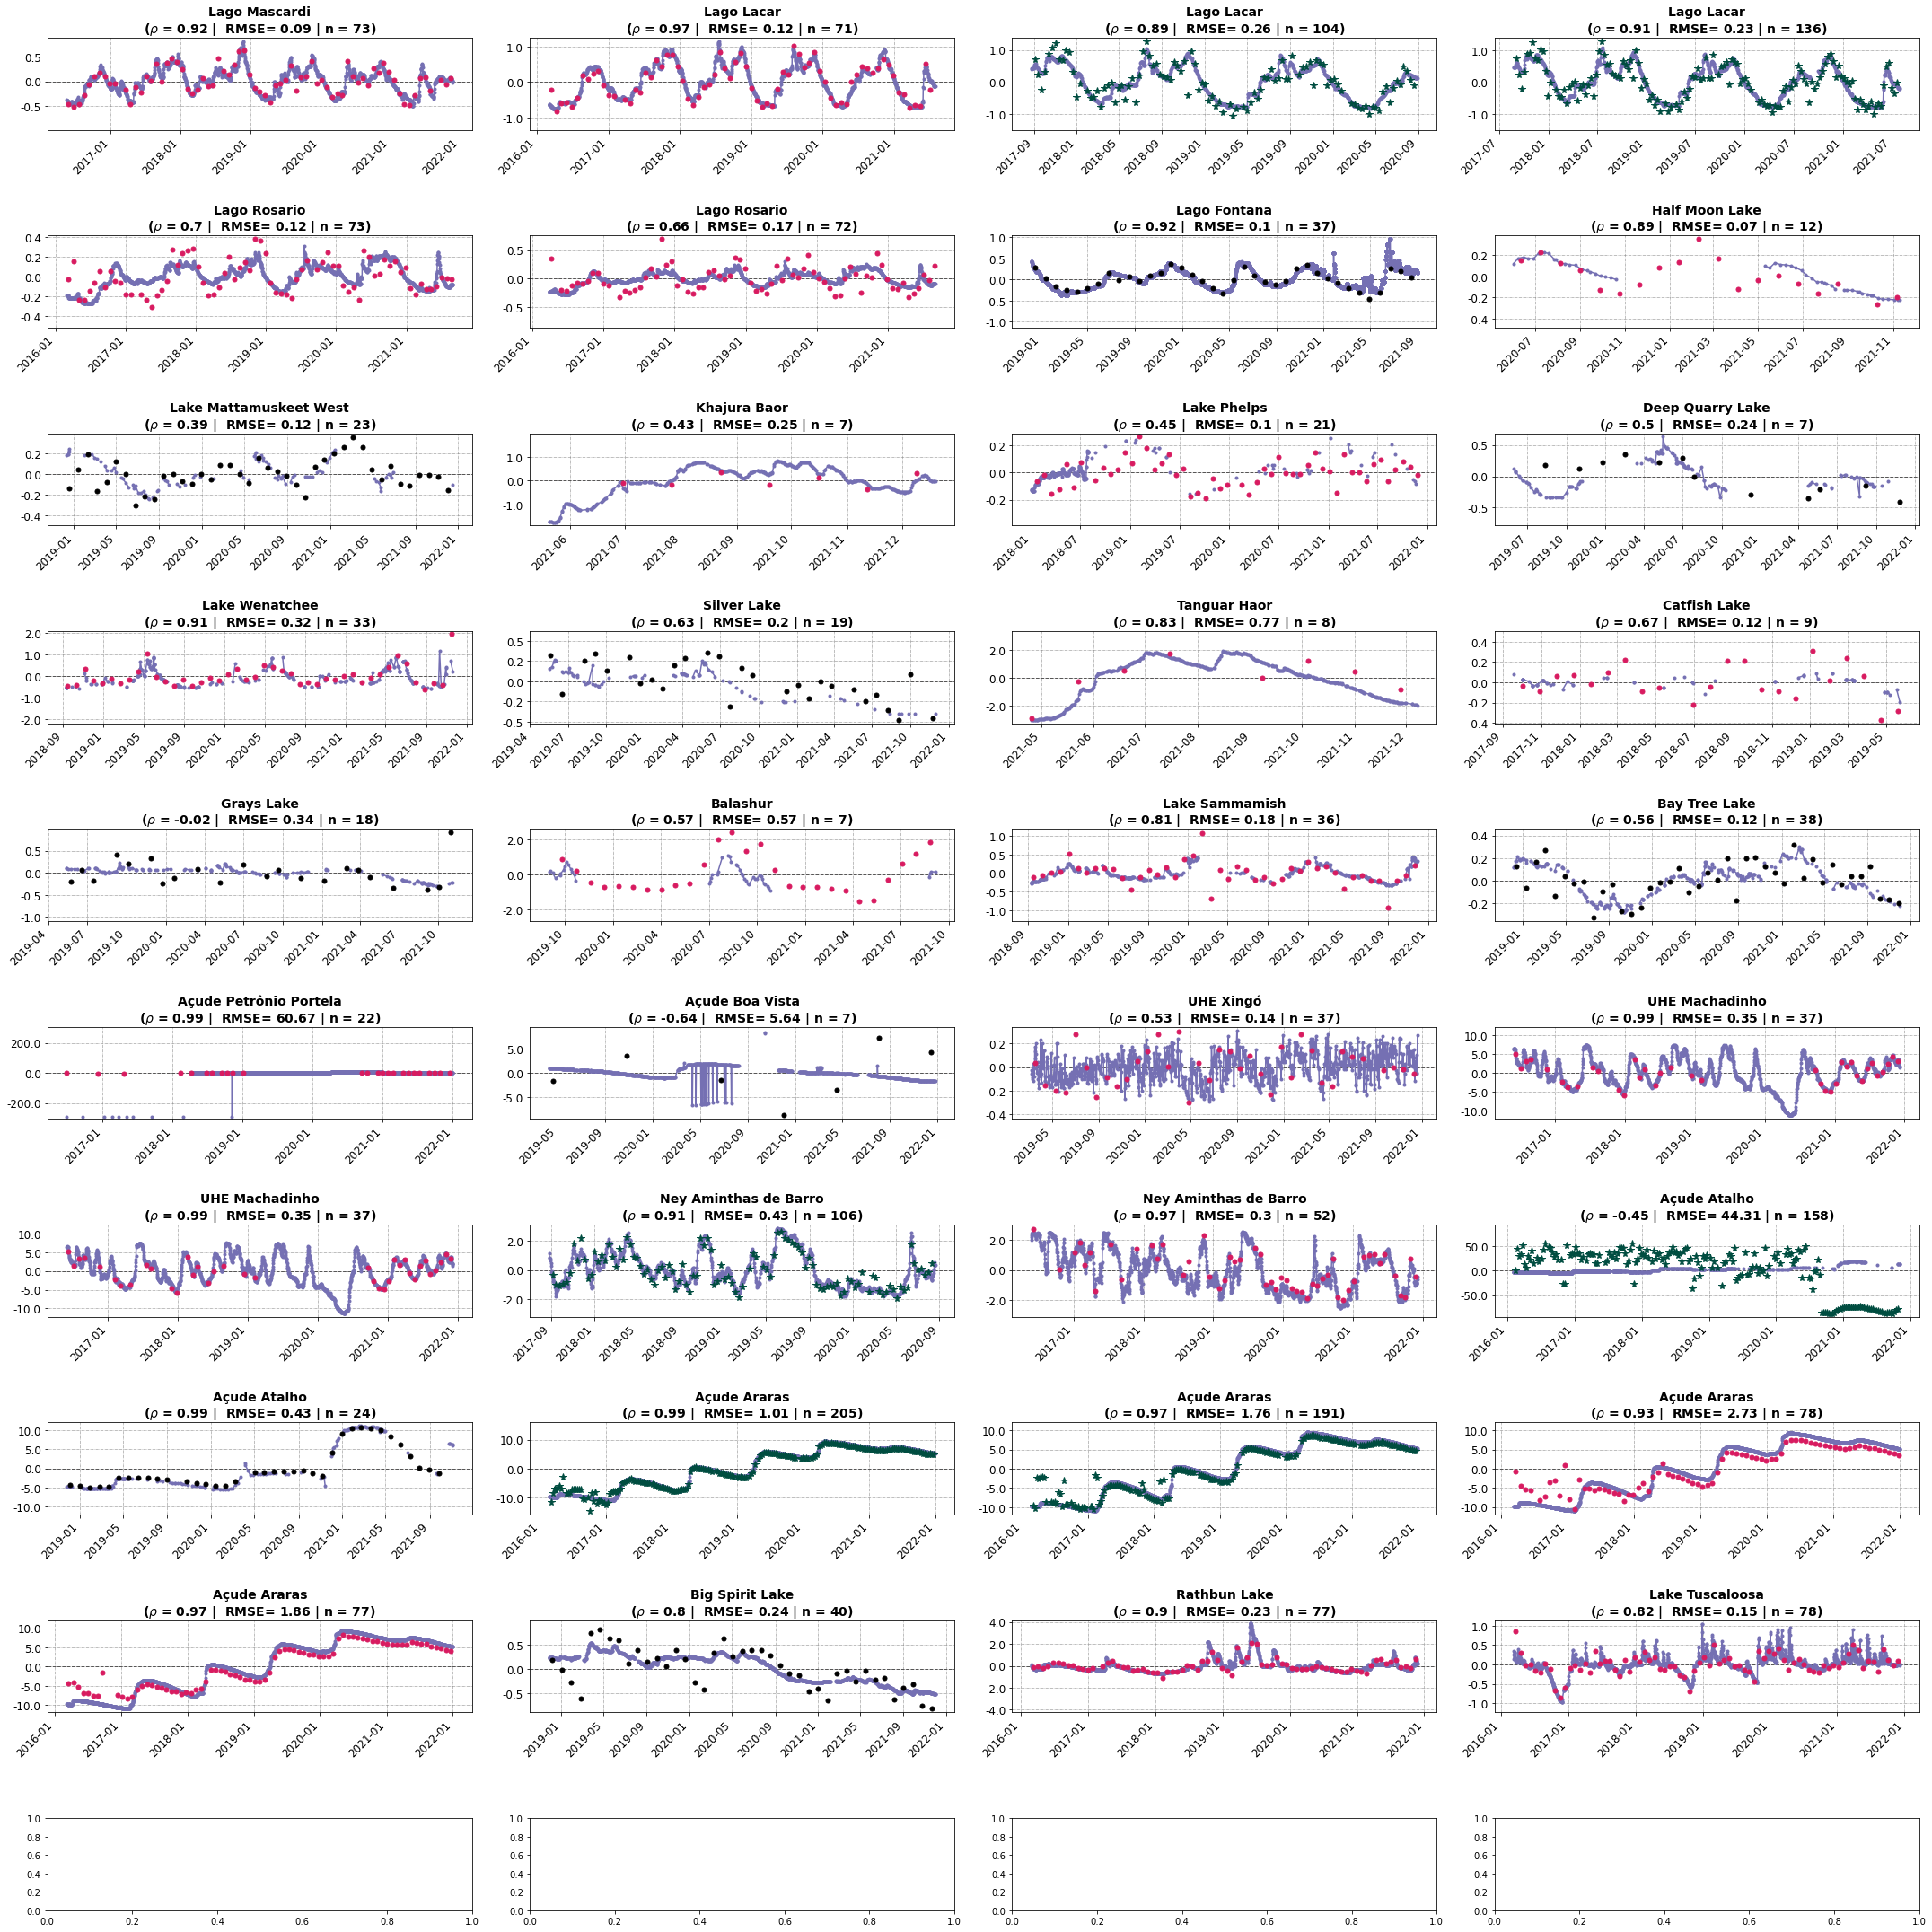

'Deep quarry freeze Sylver probably freez Half Moon too. Grays does freeze '

In [89]:
#Test to determine potential number of figures
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'


if platform.system()=='Linux':
    altis_csv=pd.read_csv(path, sep=',',encoding='iso-8859-1')
else:
    altis_csv=pd.read_csv(path, sep=',', encoding='windows-1252')  


altis_csv.shape

#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'

time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
# path_name='../data/results/plots_mv_'+time_fig+'/'

# if save_plot:
#     output_f=path_name
# else:
#     output_f=None

if start==0:
    df_final_altis=pd.DataFrame()
    df_final_ground=pd.DataFrame()
    df_cm=pd.DataFrame()
    

# path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'


tf=TimezoneFinder()

#Filter to lakes approved
#---------------------------

approve_locss=df_sel_lakes.loc[df_sel_lakes['AprovedFor']==1]['gauge_id'].values #['HMT2','PHN2','SAW2','BTN2','QUL2', 'WEW2', 'CFN2','YSL2','SLL2','TAB2','KHB2']
altis_csv=altis_csv.loc[altis_csv['station_id'].isin(approve_locss)]

#----------------------------------------

df_gts=df_ground_ts.copy()

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999

wse_ref='e'

i=1
#################CHANGE WITH N COMPARISON ####################
#----ALL
row_f=10
col_f=4
w=30
h=30
this_source='ALL'

#----ARHN
# row_f=2
# col_f=4
# w=15
# h=10
# this_source='ARHN'

##---LOCSS
# row_f=5
# col_f=3
# w=25
# h=20
# this_source='LOCSS'

#---USGS
# row_f=3
# col_f=1
# w=15
# h=18
# this_source='USGS'

##----RVBR
# row_f=5
# col_f=3
# w=30
# h=15
# this_source='RVBR'

#-----ICECV

# row_f=4
# col_f=4
# w=20
# h=15
# this_source='ICECV'
###########################################################
if this_source not in ['ALL', 'ICECV']:
    altis_csv=altis_csv.loc[altis_csv['source']==this_source].copy()

data_source=this_source

altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
#filter only altis time series with ground observations
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]

fig, axs=plt.subplots(row_f,col_f, figsize=(w,h))
axs=axs.ravel()
x_ax=0
y_ax=0
c=0
altis_w_gts_csv=altis_w_gts_csv.sort_values(by='source')
for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    ncolgeoid=row['ncolgeoid']
    # Call every altis relative to the ellipsoide
    
    # is_Sentinel=altis_name.find('Sentinel-3')
    # if is_Sentinel!=-1:
    if ncolgeoid!='No':
        #Call the function with geoid field and wse_type='e'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,
                                                        nodataalti,ncolgeoid=ncolgeoid,wse_ref=wse_ref)
    else:
        #Call the function with geoid field and wse_type='g'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    print('Station '+row['tz']+' ncolgeoid: '+str(ncolgeoid).upper(), 'Lake ID: '+st_id+' ground_st: '+str(not df_ground_st.empty)+' df_altis: '+str(df_altis.shape))
    # print(df_altis.columns)
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        lake_name=df_ground_st['lake_name'].iloc[0]
        #Convert time in df_gts_st to UTC
        source=df_ground_st['source'].iloc[0]
        
        df_ground_st['date_utc']=[timezone(row['tz']).localize(date).astimezone(utc.zone) for date in df_ground_st[st_date_fd]]
        
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st['altis_d_1']=altis_name
        
        #Get the dates of altis
        # ic(df_altis[altis_date_fd].dt.normalize().max())
        (df_altis_c, df_ground_c)=get_common_period(df_ts1=df_altis, df_ts2=df_ground_st, 
                                                    date_ts1_fd=altis_date_fd, date_ts2_fd='date_utc', delta_days=True, ndays=10)

#         
        
        if source=='USGS':
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=False)
        else:
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_c=df_ground_c.sort_values(by=['decimal_y'])
        df_altis_c=df_altis_c.sort_values(by=['decimal_y'])
        # print(df_altis_c.head())
        delta=5
        median_fd='median_d_'+str(delta)
        mean_fd='mean_d_'+str(delta)
        std_fd='std_d_'+str(delta)
        count_fd='count_d_'+str(delta)
        
       
        #Get moving windows
        df_altis_c[[median_fd,mean_fd, std_fd,count_fd]]=df_altis_c.apply(lambda x: moving_window_around_date(df_ground_c,
                                                                                                              x[altis_date_fd],
                                                                                                              delta,
                                                                                                              'height',
                                                                                                              'date_utc'), axis=1).apply(pd.Series)

        
        metrics=get_comp_metrics(ts_obs=df_altis_c[median_fd].to_numpy(),ts_est=df_altis_c['height'].to_numpy())
        
        #Add coef variation of the observations
        
        cv=np.nanstd(df_altis_c[median_fd].to_numpy())/np.nanmean(df_altis_c[median_fd].to_numpy())*100
        std_obs=np.nanstd(df_altis_c[median_fd].to_numpy())
        mean_obs=np.nanmean(df_altis_c[median_fd].to_numpy())
        
        # ic(st_id,std_obs,mean_obs)
        # if mean_obs is np.nan:
        # ic(df_altis_c[median_fd].to_numpy())
            # break

        # Add to the output dataframe the range of dates of analysis in UTC
        altis_min_utc_date=df_altis_c['date'].dt.normalize().min()
        altis_max_utc_date=df_altis_c['date'].dt.normalize().max()
        ground_min_utc_date=df_ground_c['date'].dt.normalize().min()
        ground_max_utc_date=df_ground_c['date'].dt.normalize().max()
        #ic(altis_min_utc_date,altis_max_utc_date,ground_min_utc_date,ground_max_utc_date)
        
        #Create a output dataframe with the metrics
        cm_dict={'station':[st_id],'lake_name':lake_name, 'altis':[altis_name], 'source':[source], 'method':['Moving Window'],
                'R':metrics['PR'],'PR_pvalue':metrics['PR_p_val'],'RHO':metrics['RHO'],'RHO_pvalue':metrics['RHO_p_val'],'NSF':metrics['NSF'],'RMSE':metrics['RMSE_ts2'],'APL':metrics['ampl_ts1'],
                'ME':metrics['me'],'VE':metrics['ve'], 'number_obs':metrics['size_obs'],'number_altis':metrics['size_est'],'cv_obs':cv,
                'sat_min_utcdate':altis_min_utc_date,'sat_max_utcdate':altis_max_utc_date,'grd_min_utcdate':ground_min_utc_date,'grd_max_utcdate':ground_max_utc_date}
        
        
        df_cmi=pd.DataFrame(cm_dict)
        
        df_cm=pd.concat((df_cm,df_cmi), axis=0)
        df_final_altis=pd.concat((df_final_altis,df_altis_c), axis=0)
        df_final_ground=pd.concat((df_final_ground,df_ground_c), axis=0)
        # print('error', me_alti_insi)
        #Superscript https://stackoverflow.com/questions/21226868/superscript-in-python-plots
        error_m_text='\n($\\rho$ = '+str(np.round(cm_dict['RHO'], decimals=2))+' | '+\
        ' RMSE= '+str(np.round(cm_dict['RMSE'],decimals=2))+' | n = '+str(cm_dict['number_obs'])+')'#+\
        # 'VE: '+str(np.round(ve_alti_insi, decimals=4))

        labels=altis_name.split('_')[2]
        # labelg=' '+st_id
        labelg=lake_name
        labeli='Interp ground to altis'

        

        dfg=df_ground_c
        dfs=df_altis_c

        # dic_intp={'decimal_y':df_altis_plot['decimal_y'].to_numpy(), 'height':inh_2_altidy}


        date_plot_fd='date'#'decimal_y'
        height_plot_fd='height'
        nfig=i
        if show_plot:
            #Add ice covered
            fill_between=None #{'fill':'SLIDE_snowIce',
                              #'lim':0.5}
            
            
            
                          
            plt.subplot(row_f,col_f,nfig)
#             https://stackoverflow.com/questions/62443158/plots-not-working-in-for-loop-i-am-getting-only-the-last-element-plot

            plot_dev_mean_publish(nfig,dfs, dfg, source, st_id, altis_name, date_plot_fd, height_plot_fd, labels, labelg, fill_between, error_m_text)
        i=i+1
if save_plot:     
    plt.savefig('../data/results/'+data_source+'_'+time_fig+'_all_icgt0.pdf')#, dpi=300, format='svg')    
    print('Figure save to:\n','../data/results/'+data_source+'_'+time_fig+'_all_icgt0.pdf')
if show_plot:
    plt.show() 

df_final_altis['method']='Moving Window'
df_final_ground['method']='Moving Window'


#Save results
if save_res:
    # ic(df_cm.head())
    #Save comparison metrics 
    df_cm['R']=[np.round(v, decimals=3) for v in df_cm['R']]
    df_cm['RHO']=[np.round(v, decimals=3) for v in df_cm['RHO']]
    df_cm['NSF']=[np.round(v, decimals=3) for v in df_cm['NSF']]
    df_cm['RMSE']=[np.round(v, decimals=3) for v in df_cm['RMSE']]
    df_cm['APL']=[np.round(v, decimals=3) for v in df_cm['APL']]
    df_cm['ME']=[np.round(v, decimals=3) for v in df_cm['ME']]
    df_cm['VE']=[np.round(v, decimals=3) for v in df_cm['VE']]
    df_cm['n_obs']=[np.round(v, decimals=3) for v in df_cm['number_obs']]
    df_cm['cv_obs']=[np.round(v, decimals=3) for v in df_cm['cv_obs']]
    #df_cm['sat_min_utcdate']=df_cm['sat_min_utcdate'].dt.stfrtime()
#     df_cm['sat_max_utcdate']=:altis_max_utc_date,
#     df_cm['grd_min_utcdate']=:ground_min_utc_date,
#     df_cm['grd_max_utcdate']=:ground_max_utc_date}
    
    cols=['station', 'altis', 'source', 'method','R','PR_pvalue','RHO','RHO_pvalue','NSF','RMSE', 'APL', 'VE','cv_obs', 'n_obs','sat_min_utcdate','sat_max_utcdate', 'grd_min_utcdate','grd_max_utcdate']     
    df_cm[cols].to_csv('../data/results/comparison_'+this_source+'_'+time_fig+'.csv', sep=',')
    print('Data save to:\n','../data/results/comparison_'+this_source+'_'+time_fig+'.csv')

'''Deep quarry freeze Sylver probably freez Half Moon too. Grays does freeze '''

In [107]:
df_final_altis.columns

Index(['decimal_y', 'height', 'year', 'month', 'day', 'hour', 'date',
       'name_altis', 'ground_st_1', 'median_d_5', 'mean_d_5', 'std_d_5',
       'count_d_5', 'method'],
      dtype='object')

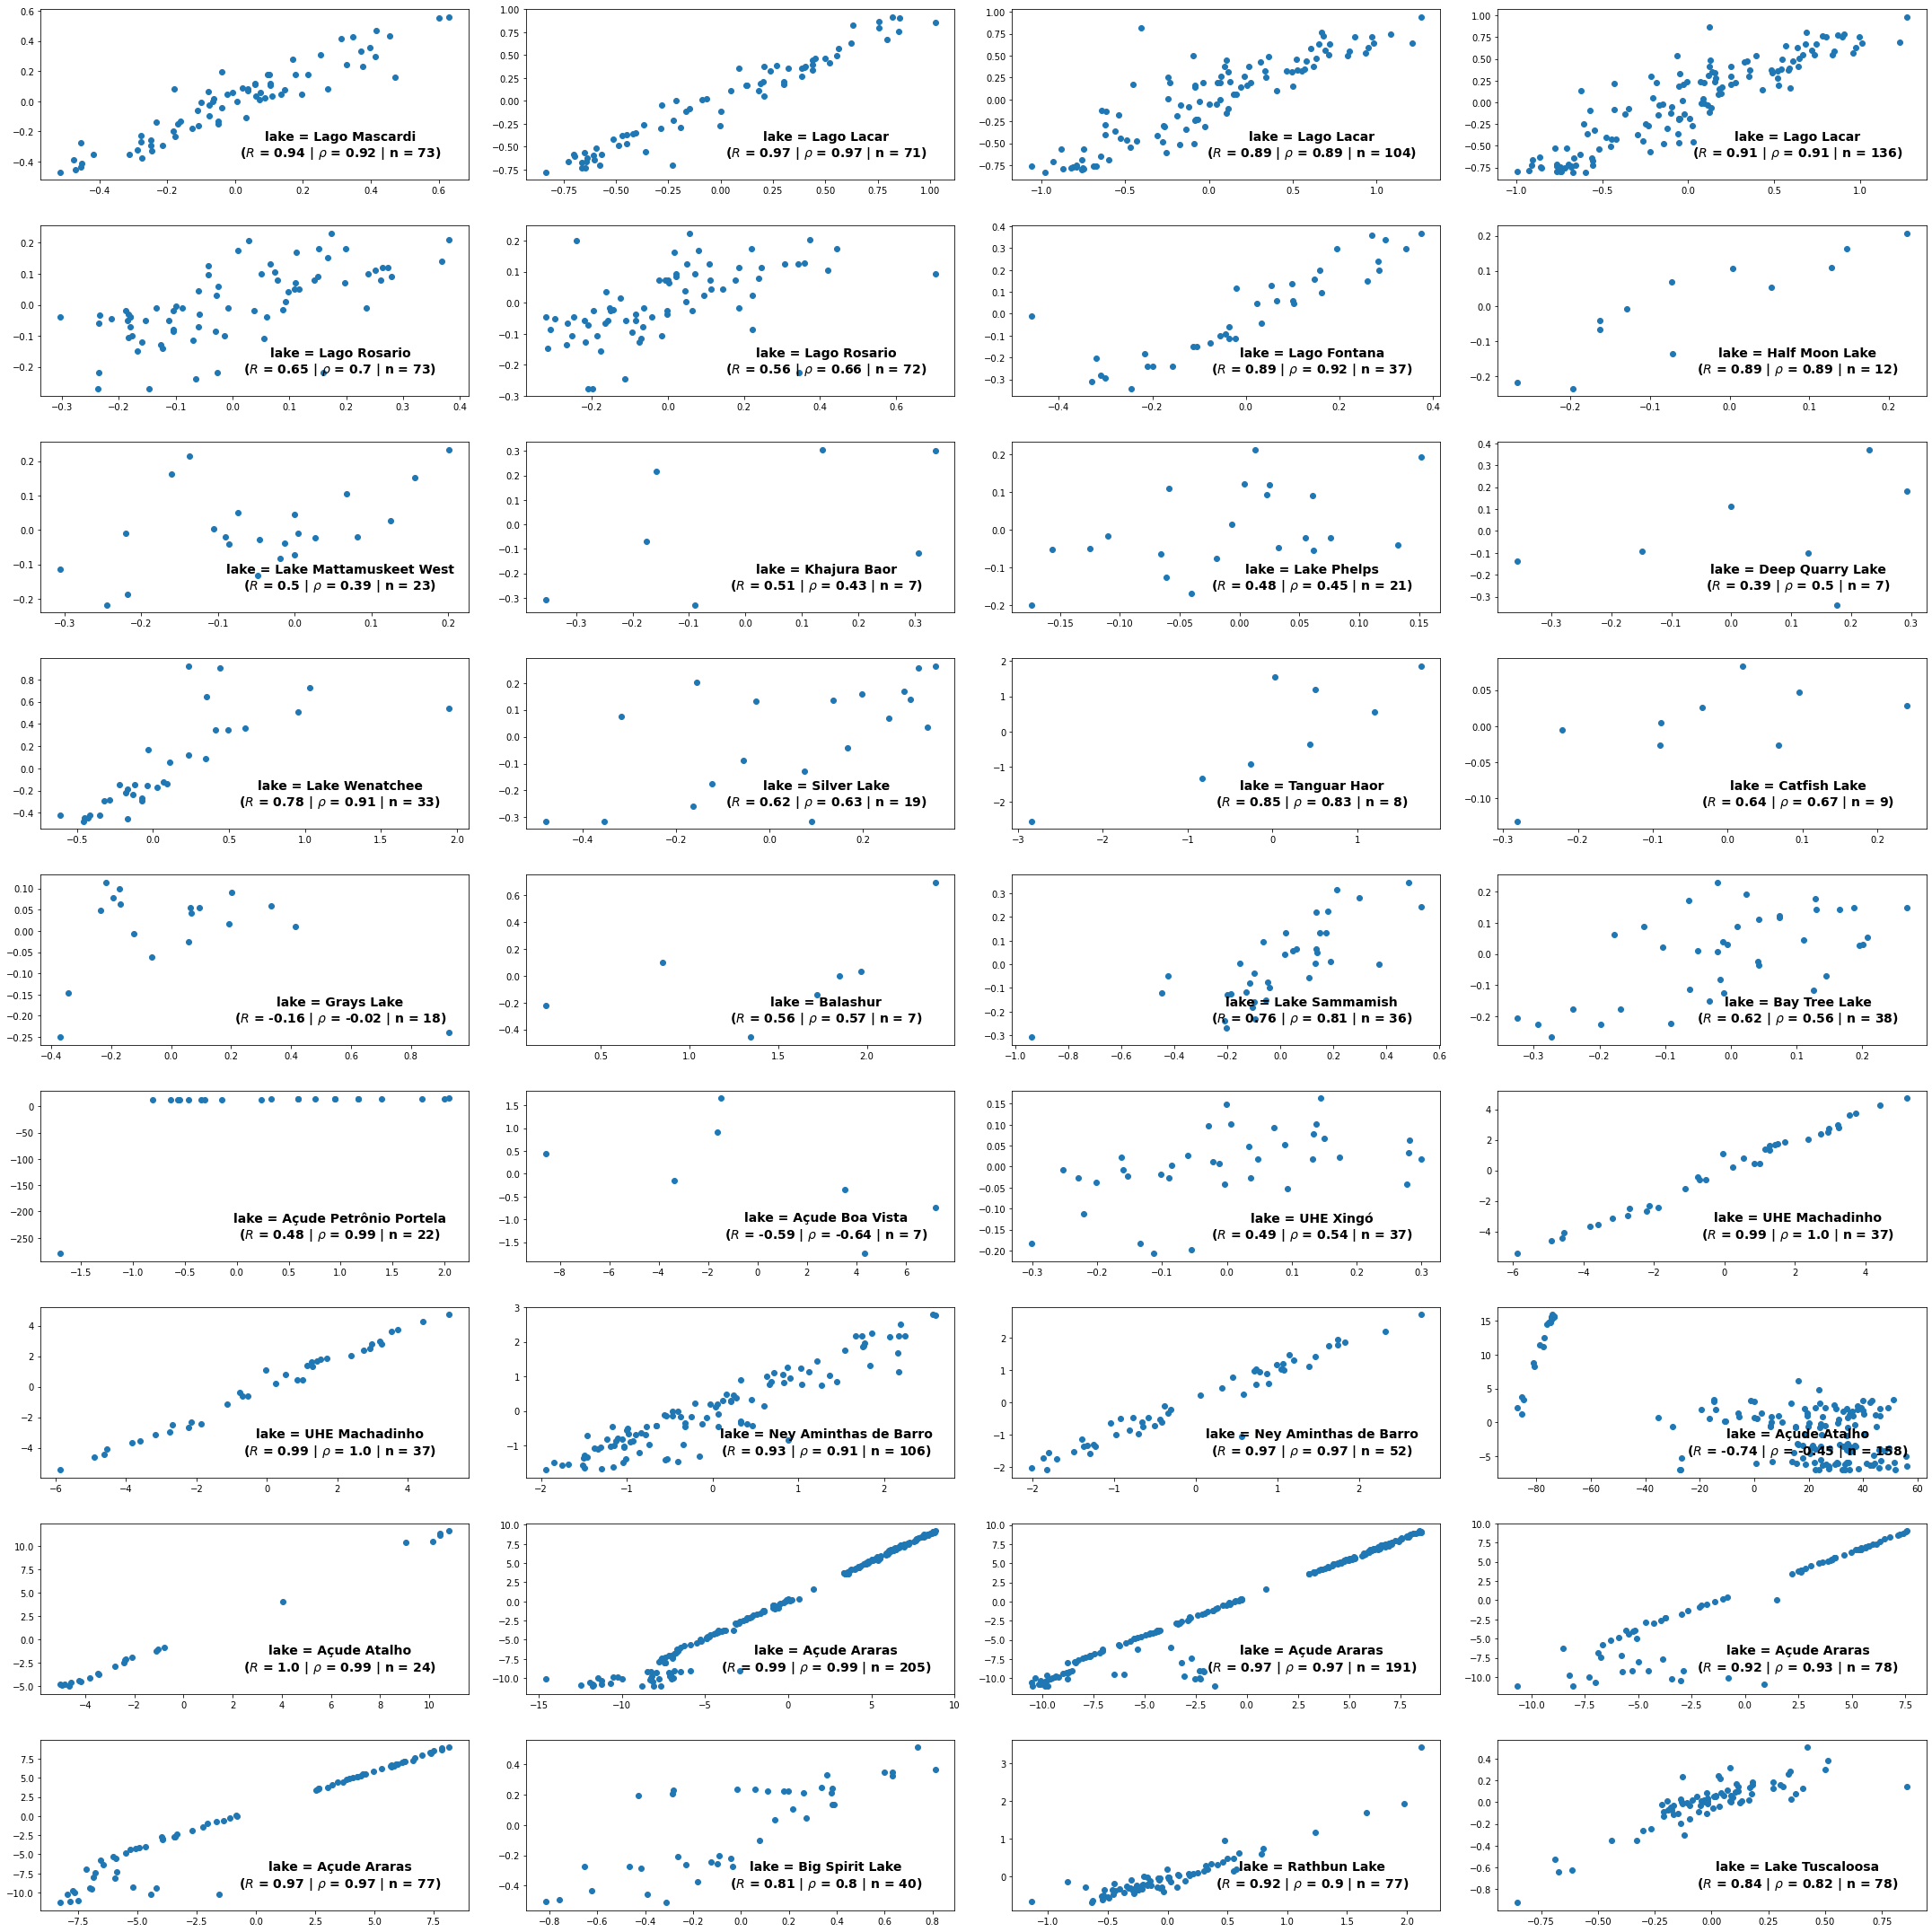

In [59]:
om='AlTiS_TimeSeries_Sentinel-3A_0562_S4128'
df_final_altis.columns


i=0
j=0
row_f=9
col_f=4
w=30
h=30
this_source='ALL'
fig, axs=plt.subplots(row_f,col_f, figsize=(w,h))
for om in df_final_altis['name_altis'].unique():
    df_val=df_final_altis.loc[df_final_altis['name_altis']==om]
    df_val
    df_metrics=df_cm.loc[df_cm['altis']==om]
    # ic(df_metrics)
    error_m_text='lake = '+df_metrics['lake_name'].iloc[0]+'\n($R$ = '+str(np.round(df_metrics['R'].iloc[0], decimals=2))+' | '+\
       '$\\rho$ = '+str(np.round(df_metrics['RHO'].iloc[0],decimals=2))+' | n = '+str(df_metrics['n_obs'].iloc[0])+')'#+\
    # df_final_ground.columns
    # fig, ax = plt.subplots()
    # plt.subplot(row_f,col_f,nfig)
    #Observed Vs Estimates
    axs[i][j].scatter(df_val['height']-np.mean(df_val['height']),df_val['median_d_5']-np.mean(df_val['median_d_5']))#, linestyle=None, marker='o')
    fig.tight_layout(h_pad=3, w_pad=2)
    axs[i][j].text(0.7,0.2,error_m_text, fontsize=14,weight='bold',
                   horizontalalignment='center', verticalalignment='center', transform=axs[i][j].transAxes)
    if j>=col_f-1:
        j=0
        if i<=row_f-1:
            i=i+1
    else:
        j=j+1
    
# axs.legend()


In [92]:
df_final_altis.head()

,decimal_y,height,year,month,day,hour,date,name_altis,ground_st_1,median_d_5,mean_d_5,std_d_5,count_d_5,method
0,2016.397797,826.443375,2016,5,25,14,2016-05-25 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,0.865,0.874,0.022211,10.0,Moving Window
1,2016.471568,826.397191,2016,6,21,14,2016-06-21 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,0.850,0.853,0.004830,10.0,Moving Window
2,2016.545338,826.459015,2016,7,18,14,2016-07-18 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,0.885,0.880,0.027889,10.0,Moving Window
3,2016.619109,826.637026,2016,8,14,14,2016-08-14 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,1.050,1.079,0.081847,10.0,Moving Window
4,2016.692879,826.851679,2016,9,10,14,2016-09-10 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,1.335,1.304,0.054813,10.0,Moving Window


In [ ]:
#Calculate metric lake variability
#using Eq 2http://wwwapp.epa.state.oh.us/dsw/nps/NPSMP/docs/JAWRA_03095_Baker.pdf

for orbit in df_final_altis['name_altis'].unique():
    df=df_final_altis.loc[df_final_altis['name_altis']==orbit].copy()
    
    df['diff_obs']=np.abs(df[median_fd].diff())
    sum_swe=df[median_fd].sum()
    diff_swe=df['diff_obs'].sum()
    rb_index=diff_swe/sum_swe
    df_cm.loc[df_cm['altis']==orbit, 'rb_index']=rb_index
    ic(df['ground_st_1'].unique()[0], rb_index)
    
    


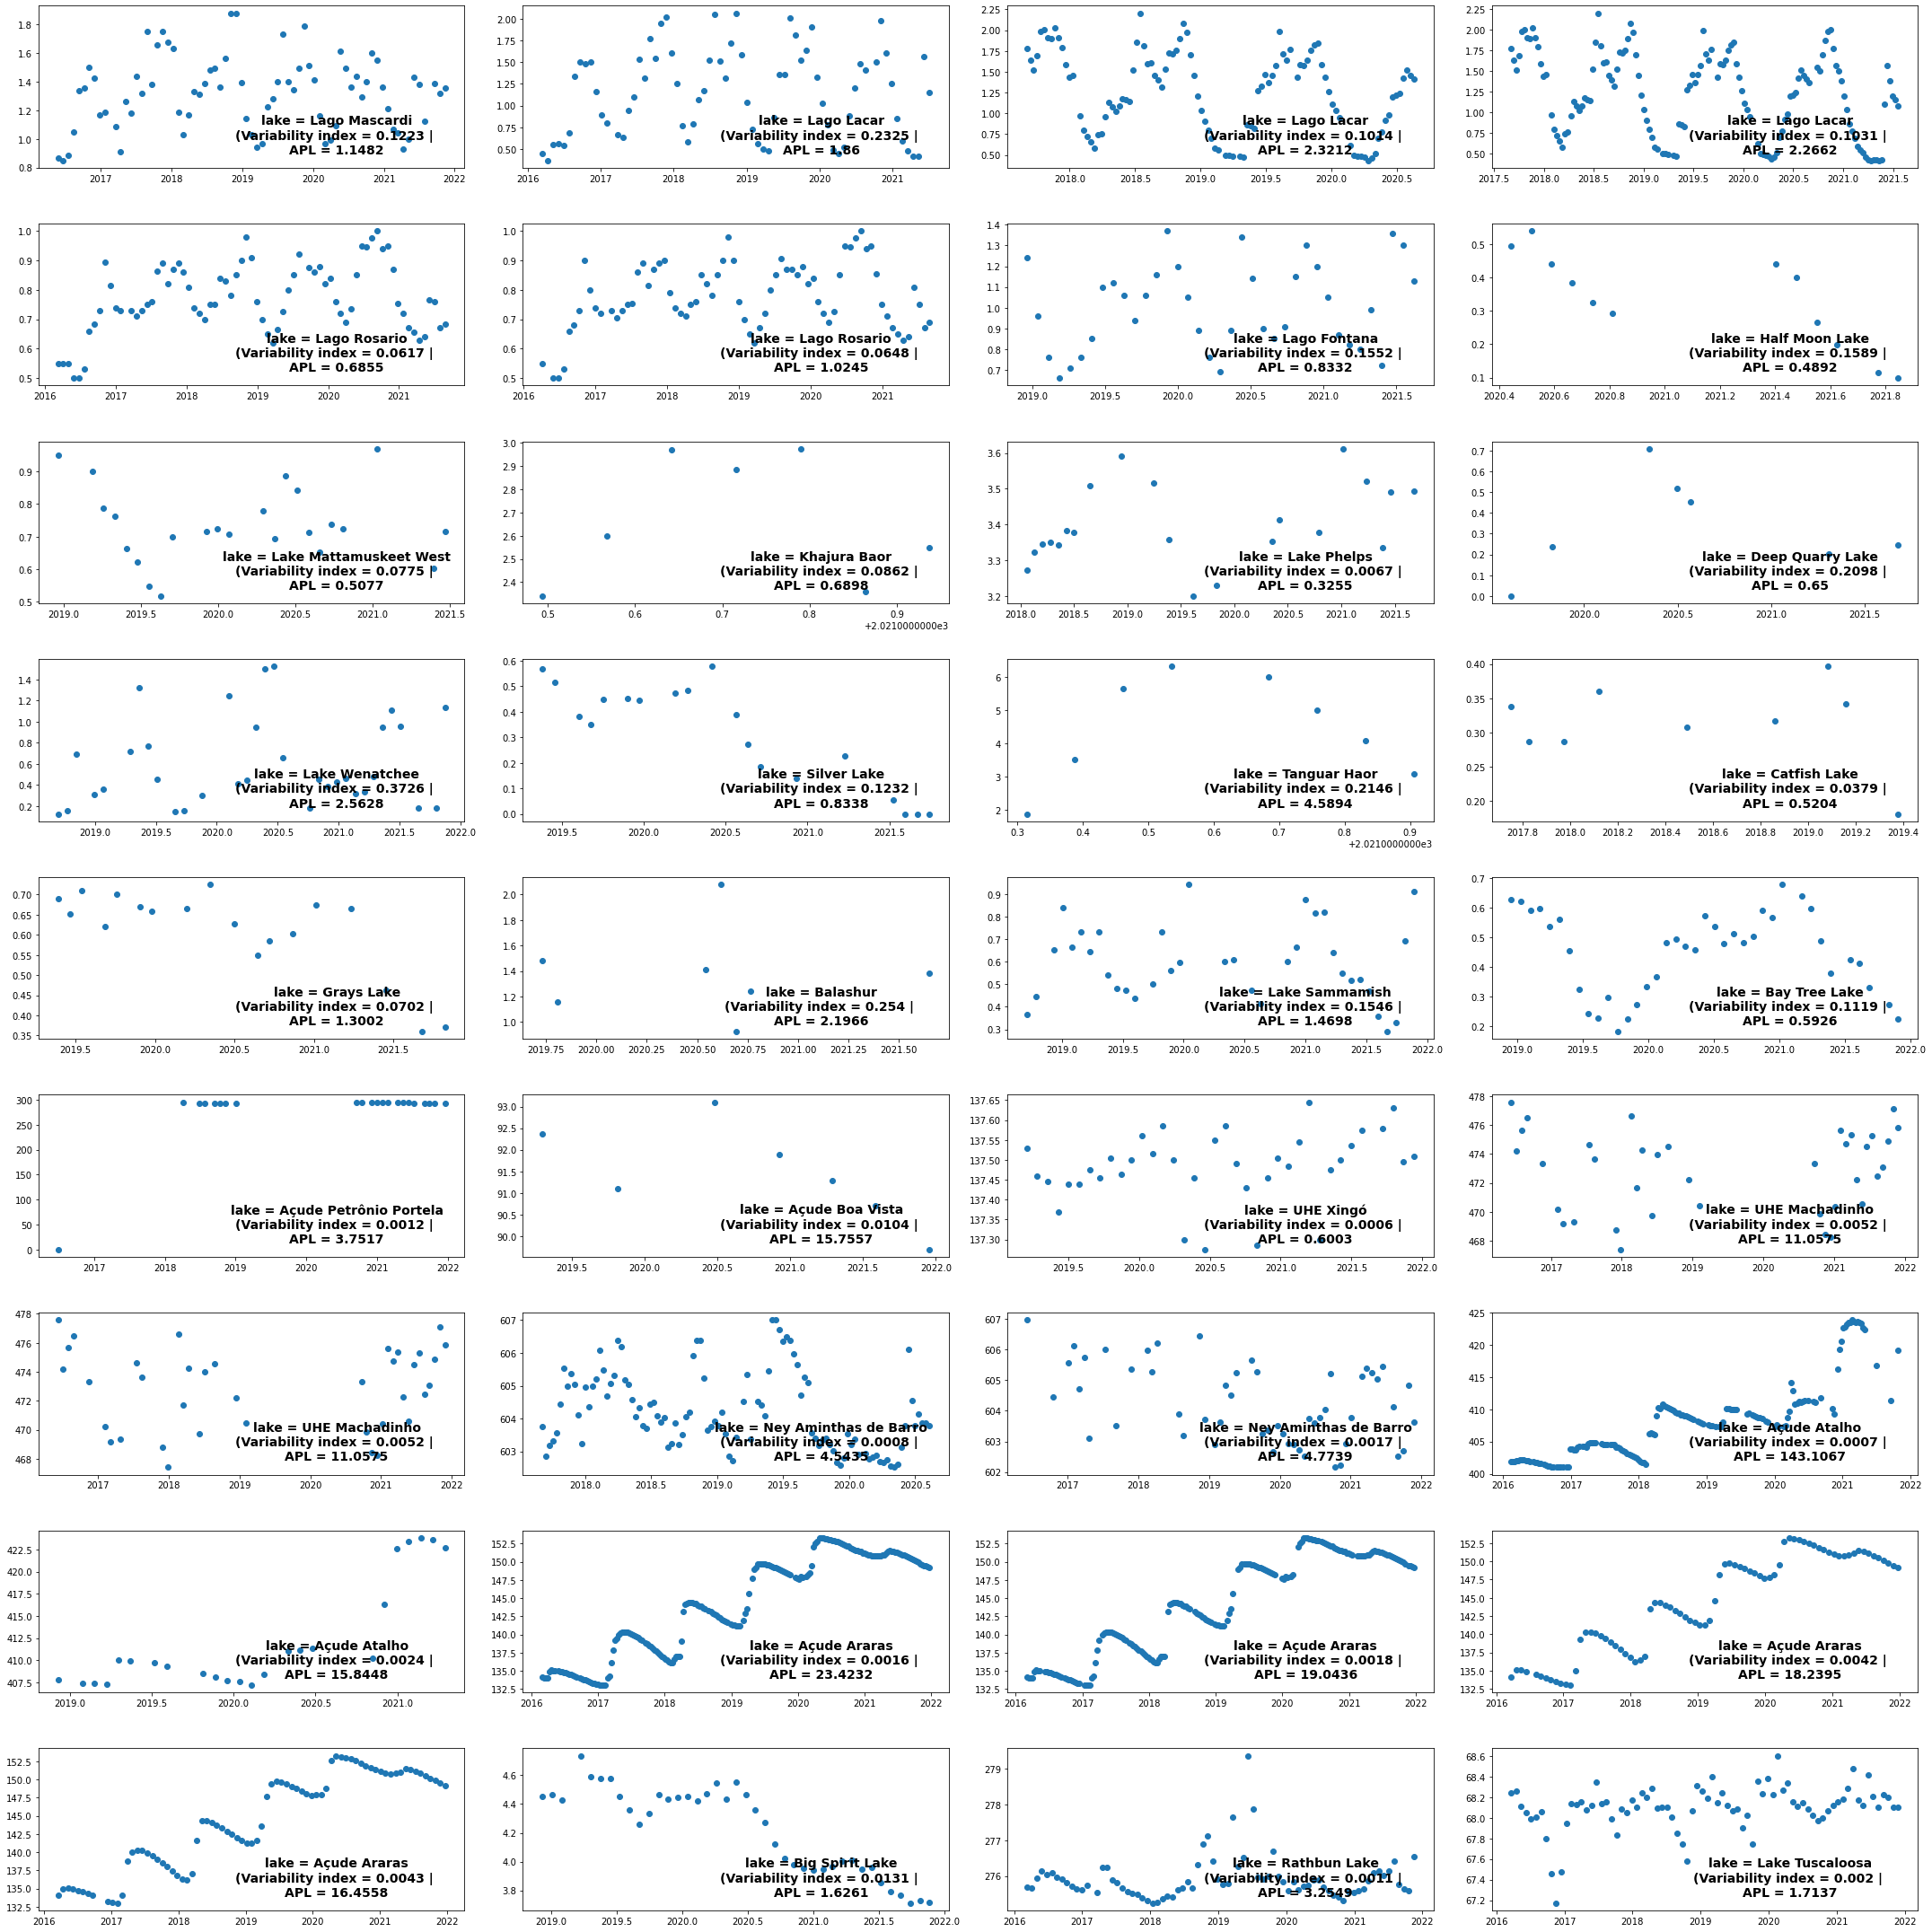

In [109]:
om='AlTiS_TimeSeries_Sentinel-3A_0562_S4128'
df_final_altis.columns


i=0
j=0
row_f=9
col_f=4
w=30
h=30
this_source='ALL'
fig, axs=plt.subplots(row_f,col_f, figsize=(w,h))
for om in df_final_altis['name_altis'].unique():
    df_val=df_final_altis.loc[df_final_altis['name_altis']==om]
    df_val
    df_metrics=df_cm.loc[df_cm['altis']==om]
    # ic(df_metrics)
    error_m_text='lake = '+df_metrics['lake_name'].iloc[0]+'\n(Variability index = '+str(np.round(df_metrics['rb_index'].iloc[0], decimals=4))+' | \n'+\
        'APL = '+str(np.round(df_metrics['APL'].iloc[0],decimals=4))#+' | n = '+str(df_metrics['n_obs'].iloc[0])+')'#+\
    # df_final_ground.columns
    # fig, ax = plt.subplots()
    # plt.subplot(row_f,col_f,nfig)
    #Observed Vs Estimates
    axs[i][j].scatter(df_val['decimal_y'],df_val['median_d_5'])#, linestyle=None, marker='o')
    fig.tight_layout(h_pad=3, w_pad=2)
    axs[i][j].text(0.7,0.2,error_m_text, fontsize=14,weight='bold',
                   horizontalalignment='center', verticalalignment='center', transform=axs[i][j].transAxes)
    if j>=col_f-1:
        j=0
        if i<=row_f-1:
            i=i+1
    else:
        j=j+1
    
# axs.legend()


In [100]:
df_cm.head()

,station,lake_name,altis,source,method,R,PR_pvalue,RHO,RHO_pvalue,NSF,...,ME,VE,number_obs,number_altis,cv_obs,sat_min_utcdate,sat_max_utcdate,grd_min_utcdate,grd_max_utcdate,rb_index
0,1824,Lago Mascardi,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,ARHN,Moving Window,0.938667,1.482146e-34,0.922702,4.145300e-31,0.881095,...,-8.265839e-14,0.008384,73,73,18.895559,2016-05-25 00:00:00+00:00,2021-11-13 00:00:00+00:00,2016-05-16,2021-11-23,0.122297
0,2028,Lago Lacar,AlTiS_TimeSeries_Sentinel-3A_0749_S4016,ARHN,Moving Window,0.973167,9.218785e-46,0.968995,1.258762e-43,0.946372,...,9.555736e-15,0.013263,71,71,43.290376,2016-03-12 00:00:00+00:00,2021-07-08 00:00:00+00:00,2016-03-02,2021-07-31,0.232501
0,2028,Lago Lacar,AlTiS_TimeSeries_Jason-3_0215_S4017,ARHN,Moving Window,0.886218,7.290972e-36,0.892176,5.476830e-37,0.784617,...,2.069392e-14,0.068505,104,104,38.312189,2017-09-03 00:00:00+00:00,2020-08-18 00:00:00+00:00,2017-08-24,2020-08-28,0.101381
0,2028,Lago Lacar,AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017,ARHN,Moving Window,0.905711,8.563824e-52,0.910803,2.469178e-53,0.820312,...,4.108478e-14,0.054292,136,136,40.680880,2017-09-03 00:00:00+00:00,2021-07-22 00:00:00+00:00,2017-08-24,2021-07-31,0.103105
0,2234,Lago Rosario,AlTiS_TimeSeries_Sentinel-3A_0635_S4324,ARHN,Moving Window,0.650217,4.802968e-10,0.695427,8.646707e-12,0.417686,...,1.073905e-13,0.015484,73,73,15.292348,2016-03-08 00:00:00+00:00,2021-08-27 00:00:00+00:00,2016-02-27,2021-08-31,0.061688


In [156]:
pd.concat([df_ground_ts['gauge_id'],df_ground_ts['lake_name']]).unique()

array(['2464800', '6903880', '6604000', '1824', '2830', '1830', '2832',
       '2028', '2231', '2234', '2300', '2316', 'BLB2', 'BTN2', 'CFN2',
       'HMT2', 'MAB2', 'MCW2', 'MRP2', 'PAW2', 'PHN2', 'QUL2', 'RLH2',
       'SAW2', 'SLL2', 'SPA2', 'WEW2', 'YSL2', '19069', '19060', '19126',
       '12030', '12036', '12327', '12056', 'KHB2', 'TAB2', 'MTN2',
       'Tuscaloosa', 'Rathbun', 'Big Spirit', 'Mascardi', nan, 'Lacar',
       'Rosario', 'Fontana', 'Balashur', 'Bay Tree', 'Catfish',
       'Half Moon', 'McIntosh Lake', 'Manchar Lake', 'Pattison Lake',
       'Phelps', 'Deep Quarry', 'Russell Pond', 'Sammamish', 'Silver',
       'Snow Pond', 'Wenatchee', 'Grays', 'UHE Machadinho',
       'Ney Aminthas de Barro', 'UHE Xingó', 'Açude Araras',
       'Açude Atalho', 'Açude Petrônio Portela', 'Açude Boa Vista',
       'Khajura Baor', 'Tanguar Haor', 'Lake Mattamuskeet West'],
      dtype=object)

In [157]:
df_ground_ts.loc[df_ground_ts['lake_name']=='Phelps']

,gauge_id,source,decimal_y,height,date,year,month,day,hour,lake_name,doy,Hylak_id,SLIDE_snowIce,diff
339660,PHN2,LOCSS,2018.489155,3.398520,2018-06-28 13:17:00,2018,6,28,13,Phelps,179,9340.0,0.013407,NaN
339661,PHN2,LOCSS,2018.489155,3.398520,2018-06-28 13:17:00,2018,6,28,13,Phelps,179,9340.0,0.000091,NaN
339662,PHN2,LOCSS,2018.609132,3.468624,2018-08-11 08:12:22,2018,8,11,8,Phelps,223,NaN,NaN,NaN
339663,PHN2,LOCSS,2018.645320,3.508248,2018-08-24 13:02:44,2018,8,24,13,Phelps,236,9340.0,0.001295,NaN
339664,PHN2,LOCSS,2018.000000,3.230880,2018-01-01 00:01:00,2018,1,1,0,Phelps,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339957,PHN2,LOCSS,2022.018151,3.371088,2022-01-07 15:05:03,2022,1,7,15,Phelps,7,NaN,NaN,NaN
339958,PHN2,LOCSS,2022.100000,3.364992,2022-02-06 12:24:05,2022,2,6,12,Phelps,37,NaN,NaN,NaN
339959,PHN2,LOCSS,2022.220320,3.352800,2022-03-22 10:43:31,2022,3,22,10,Phelps,81,9340.0,0.000003,NaN
339960,PHN2,LOCSS,2022.253311,3.535680,2022-04-03 11:35:01,2022,4,3,11,Phelps,93,9340.0,0.000000,NaN


In [95]:
'../data/results/'+data_source+'_'+time_fig+'_all.png'

'../data/results/ICECV_20220526_08_50_all.png'

In [96]:
save_plot

True

In [111]:
df_cm

,station,altis,source,method,r2,NSF,RMSE,APL,ME,VE,number_obs,number_altis
0,1824,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,ARHN,Moving Window,0.938715,0.865378,0.091532,1.030000,8.262188e-14,0.008378,73,73
0,2028,AlTiS_TimeSeries_Sentinel-3A_0749_S4016,ARHN,Moving Window,0.973179,0.946392,0.115218,1.695000,-9.533845e-15,0.013275,71,71
0,2028,AlTiS_TimeSeries_Jason-3_0215_S4017,ARHN,Moving Window,0.886484,0.708670,0.261445,1.770000,-2.092664e-14,0.068353,104,104
0,2028,AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017,ARHN,Moving Window,0.906064,0.781520,0.232592,1.785000,-4.086764e-14,0.054099,136,136
0,2234,AlTiS_TimeSeries_Sentinel-3A_0635_S4324,ARHN,Moving Window,0.652363,-0.115740,0.124084,0.500000,-1.074559e-13,0.015397,73,73
0,2234,AlTiS_TimeSeries_Sentinel-3A_0676_S4325,ARHN,Moving Window,0.560191,-1.378686,0.174566,0.500000,7.889214e-14,0.030473,72,72
0,2316,AlTiS_TimeSeries_Sentinel-3B_0020_S4492,ARHN,Moving Window,0.891357,0.773340,0.097216,0.710000,-9.203149e-14,0.009451,37,37
0,BTN2,AlTiS_TimeSeries_Sentinel-3B_0691_N3466,LOCSS,Moving Window,0.622740,0.177504,0.123829,0.496824,-4.959483e-16,0.015334,38,38
0,CFN2,AlTiS_TimeSeries_Sentinel-3A_0035_N3493,LOCSS,Moving Window,0.636623,-3.705776,0.123482,0.214884,3.164136e-15,0.015248,9,9
0,HMT2,AlTiS_TimeSeries_Sentinel-3A_0351_N5346,LOCSS,Moving Window,0.886224,0.752355,0.068395,0.442000,-1.042014e-13,0.004678,12,12


In [10]:
# #Do the linear interpolation to get the accuracies

#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
path_name='../data/results/plots_it_'+time_fig+'/'

if save_plot:
    output_f=path_name
else:
    output_f=None

if start==0:
    df_final_altis=pd.DataFrame()
    df_final_ground=pd.DataFrame()
    df_cm=pd.DataFrame()

# #Read shapefile with all the coordinates and the id of the files

path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'
# altis_shp
#altis_shp=gpd.read_file(path)
altis_csv=pd.read_csv(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()
# altis_shp['tz']=[tf.timezone_at(lng=row[0], lat=row[1]) for row in altis_shp[[lon_fd, lat_fd]]]


# altis_shp['tz']=altis_shp.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)

#filter only altis time series with ground observations
# altis_w_gts_shp=altis_shp.loc[altis_shp['station_id'].notna()]
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]


#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
df_gts=df_ground_ts

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999

wse_ref='e'
ncolgeoid='geoid_01_median' #PENDING RAISE AND HANDLE THE EXCEPTION WHEN geoid column not found

    
i=1

for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    ncolgeoid=row['ncolgeoid']
    # Call every altis relative to the ellipsoide
    
    # is_Sentinel=altis_name.find('Sentinel-3')
    # if is_Sentinel!=-1:
    if ncolgeoid!='No':
        #Call the function with geoid field and wse_type='e'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,
                                                        nodataalti,ncolgeoid=ncolgeoid,wse_ref=wse_ref)
    else:
        #Call the function with geoid field and wse_type='g'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    print('Station '+row['tz']+' ncolgeoid: '+str(ncolgeoid).upper(), st_id+' ground_st: '+str(not df_ground_st.empty)+
          ' df_altis: '+str(df_altis.shape)+' df_ground_st: '+str(df_ground_st.shape))
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        #Convert time in df_gts_st to UTC
        source=df_ground_st['source'].iloc[0]
        #if source !='RVBR':
        #     continue
            
       # df_ground_st['date_utc']=df_ground_st[st_date_fd].dt.tz_localize(row['tz']).dt.tz_convert('utc')
        df_ground_st['date_utc']=[timezone(row['tz']).localize(date).astimezone(utc.zone) for date in df_ground_st[st_date_fd]]
        # Cut the time series to the same period the time series
        (df_altis_c, df_ground_c)=get_common_period(df_ts1=df_altis, df_ts2=df_ground_st, 
                                             date_ts1_fd=altis_date_fd, date_ts2_fd='date_utc', delta_days=False, ndays=0)
       
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        #Recalculate date with dates in utc
        if source=='USGS':
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=False)
        else:
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_c=df_ground_c.sort_values(by=['decimal_y'])
        df_altis_c=df_altis_c.sort_values(by=['decimal_y'])
        
        df_ground_c['altis_d_1']=altis_name


        (inh_2_altidy, corr_alti_insi, ns_alti_insi, rmse_alti_insi,
         ampl_insi) = interp_ts12ts2_stat(df_ground_c['decimal_y'].to_numpy(), df_ground_c['height'].to_numpy(), 
                                          df_altis_c['decimal_y'].to_numpy(), df_altis_c['height'].to_numpy())
        
        
                #Create a output dataframe with the metrics
        cm_dict={'station':[st_id], 'altis':[altis_name], 'source':[source], 'method':['Linear Interpolation'],
                'R':[corr_alti_insi],'NSF':[ns_alti_insi],'RMSE':[rmse_alti_insi],'APL':[ampl_insi]}
        df_cmi=pd.DataFrame(cm_dict)
        
        #Concat to final dataframes 
        df_final_altis=pd.concat((df_final_altis, df_altis_c), axis=0)
        df_final_ground=pd.concat((df_final_ground, df_ground_c), axis=0)
        
        df_cm=pd.concat((df_cm,df_cmi), axis=0)
        
        error_m_text='\nR: '+str(np.round(corr_alti_insi, decimals=2))+' | '+\
        'NSE: '+str(np.round(ns_alti_insi,decimals=2))+'\n'+\
        'RMSE: '+str(np.round(rmse_alti_insi,decimals=2))+' | '+\
        'Max Min diff: '+str(np.round(ampl_insi,decimals=2))+'\n'+\
        'Method: Linear interpolation'
        
        
        labels=altis_name
        labelg='Ground Obs '+source+' '+st_id
        labeli='Interp ground to altis'


        dfs=df_altis_c
        dfg=df_ground_c
        print('dimension ground altis', str(dfg.shape)+' '+str(dfs.shape))
        dic_intp={'decimal_y':df_altis_c['decimal_y'].to_numpy(), 'height':inh_2_altidy}

        dfi=pd.DataFrame(dic_intp)
        date_plot_fd='decimal_y'
        height_plot_fd='height'
        nfig=i
        if show_plot:
            p=plot_dev_mean(nfig,dfs, dfg, dfi, source, st_id, altis_name, date_plot_fd, height_plot_fd, labels, labelg, labeli, error_m_text, output_f)
            p.show()
            p.close()

        i=i+1
        
        
df_final_altis['method']='Linear interp'    
df_final_ground['method']='Linear interp'    



Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN 1824 ground_st: True df_altis: (73, 8) df_ground_st: (8037, 9)
dimension ground altis (1998, 11) (73, 9)
Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN 2028 ground_st: True df_altis: (77, 8) df_ground_st: (31001, 9)
dimension ground altis (1925, 11) (72, 9)
Station America/Argentina/Salta ncolgeoid: GEOID_EIGEN6C4D_MEDIAN 2028 ground_st: True df_altis: (104, 8) df_ground_st: (31001, 9)
dimension ground altis (1082, 11) (104, 9)
Station America/Argentina/Salta ncolgeoid: GEOID_MEDIAN 2028 ground_st: True df_altis: (157, 8) df_ground_st: (31001, 9)
dimension ground altis (1399, 11) (138, 9)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2234 ground_st: True df_altis: (76, 8) df_ground_st: (26584, 9)
dimension ground altis (2003, 11) (73, 9)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2234 ground_st: True df_altis: (75, 8) df_ground_st: (26584, 9)
dimension ground altis (1974, 11) (72

In [6]:
#Plot methods comparison metrics
import seaborn as sns
import matplotlib as plt
import pandas as pd

sns.set_style('white')
sns.set_context('notebook')#, font_scale=1.5)

# df=df_cm.copy()
df=pd.read_csv('../data/results/comparison_20220412_18_40.csv', sep=',')

df_t=pd.melt(df, id_vars=['station', 'altis', 'source', 'method','area_skm'], value_vars=['R','NSF','RMSE','APL'], ignore_index=True)
df_t['mission']=[x.split('_')[2] for x in df_t['altis']]
# df_t['to_plot_m']=[x.split('_')[2] for x in df_t['mission'] if x]
df_t.loc[df_t['mission'].isin(['Sentinel-3B','Jason-3']),'to_plot_m']=1
df_t.loc[~df_t['mission'].isin(['Sentinel-3B','Jason-3']),'to_plot_m']=0
df_t=df_t.loc[df_t['area_skm'].notna()]
# df['st_alti']
df_t.head()

,station,altis,source,method,area_skm,variable,value,mission,to_plot_m
0,1824,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,ARHN,Moving Window,36.62,r2,0.939,Sentinel-3A,0.0
1,2028,AlTiS_TimeSeries_Sentinel-3A_0749_S4016,ARHN,Moving Window,50.67,r2,0.973,Sentinel-3A,0.0
3,2028,AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017,ARHN,Moving Window,50.67,r2,0.906,Jason-3,1.0
4,2234,AlTiS_TimeSeries_Sentinel-3A_0635_S4324,ARHN,Moving Window,8.90,r2,0.652,Sentinel-3A,0.0
5,2234,AlTiS_TimeSeries_Sentinel-3A_0676_S4325,ARHN,Moving Window,8.90,r2,0.560,Sentinel-3A,0.0


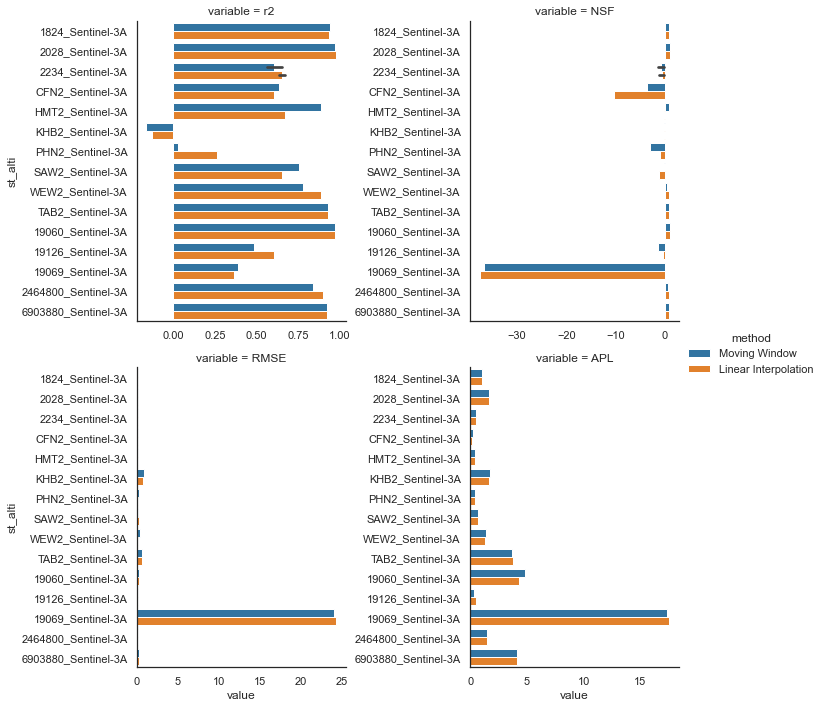

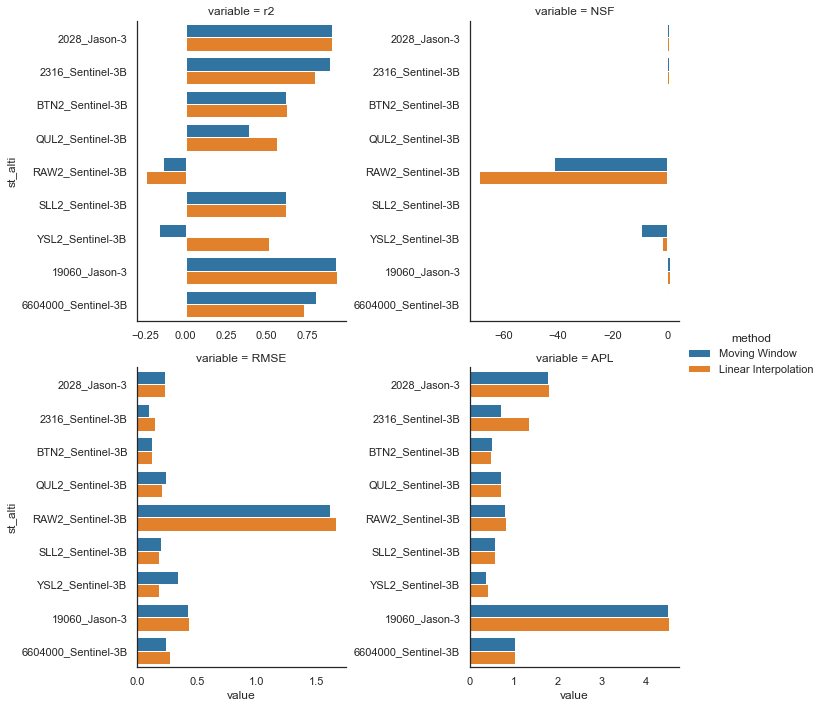

In [7]:
for s in df_t['to_plot_m'].unique():
    df=df_t.loc[df_t['to_plot_m']==s].copy()
    df['st_alti']=df.apply(lambda x:str(x['station'])+'_'+x['mission'], axis=1) #LO QUE NECESITA ES ESTO
    x_fd='value'
    y_fd='st_alti'
    hue='method'
    col='variable'
    row='variable'#'source'
    g = sns.catplot(data=df,sharex=False,sharey=False,
                x=x_fd, y=y_fd,
                hue=hue, #col=col,
                col=row, col_wrap=2,
                kind="bar",
                dodge=True)
    #                height=4, aspect=.7)
    g
    del df

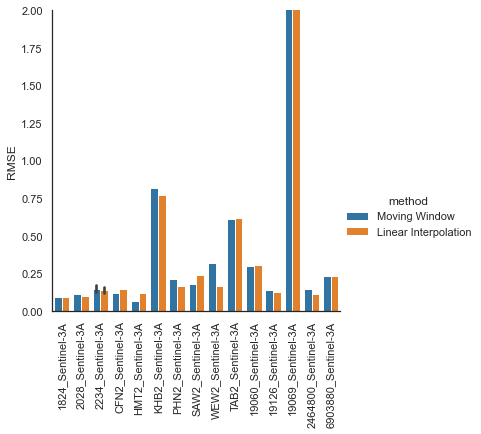

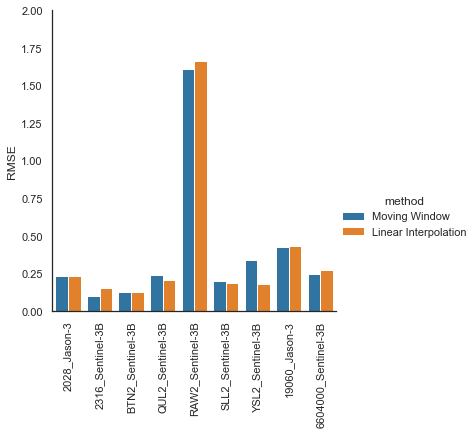

In [15]:
for s in df_t['to_plot_m'].unique():
    df=df_t.loc[df_t['to_plot_m']==s].copy()
    df['st_alti']=df.apply(lambda x:str(x['station'])+'_'+x['mission'], axis=1) #LO QUE NECESITA ES ESTO
    df=df.loc[df['variable']=='RMSE']
    x_fd='st_alti'
    y_fd='value'
    hue='method'
    #col='variable'
    #row='variable'#'source'
    g = sns.catplot(data=df,sharex=False,sharey=False,
                x=x_fd, y=y_fd,
                hue=hue, #col=col,
     #           col=row, col_wrap=2,
                kind="bar",
                dodge=True)
    #                height=4, aspect=.7)
    g
    g.set_xticklabels(rotation=90)
    g.set_axis_labels(x_var='',y_var='RMSE')
    g.set(ylim=(0,2))
    del df

  station                                      altis source         method  \
0    1824    AlTiS_TimeSeries_Sentinel-3A_0562_S4128   ARHN  Moving Window   
1    2028    AlTiS_TimeSeries_Sentinel-3A_0749_S4016   ARHN  Moving Window   
3    2028  AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017   ARHN  Moving Window   
4    2234    AlTiS_TimeSeries_Sentinel-3A_0635_S4324   ARHN  Moving Window   
5    2234    AlTiS_TimeSeries_Sentinel-3A_0676_S4325   ARHN  Moving Window   

   area_skm variable  value      mission           st_alti  
0     36.62       r2  0.939  Sentinel-3A  1824_Sentinel-3A  
1     50.67       r2  0.973  Sentinel-3A  2028_Sentinel-3A  
3     50.67       r2  0.906      Jason-3      2028_Jason-3  
4      8.90       r2  0.652  Sentinel-3A  2234_Sentinel-3A  
5      8.90       r2  0.560  Sentinel-3A  2234_Sentinel-3A  


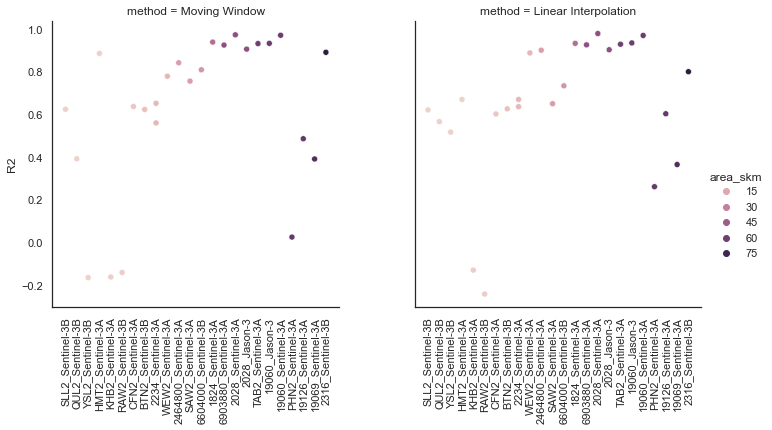

In [3]:
df=df_t.copy()
df['st_alti']=df.apply(lambda x:str(x['station'])+'_'+x['mission'], axis=1) #LO QUE NECESITA ES ESTO
# df=df.loc[df['variable'].isin(['R', 'RMSE'])]
df=df.loc[df['variable']=='R']
# sns.set(rc = {'figure.figsize':(10,2)})
sns.set_style('white')

print(df.head())
df=df.sort_values(by=['area_skm'])
x_fd='st_alti'
y_fd='value'
hue='area_skm'#'method'
col='variable'
row='method'#'source'
# for i in ['r2', 'RMSE']:
# df=df.loc[df[col]==i]
g = sns.relplot(data=df,#sharex=False,sharey=False,
        x=x_fd, y=y_fd,
        hue=hue, col=row,
        #col=row,# col_wrap=2,
        kind="scatter")#,
            #join=False)#,
        #dodge=True)
#                height=4, aspect=.7)
g
g.set_xticklabels(rotation=90)
g.set_axis_labels(x_var='', y_var='R')
# g.set(ylim=(0,2))
del df
# g = sns.catplot(data=df,sharex=False,sharey=False,
#             x=x_fd, y=y_fd,
#             hue=hue, #row=row,
#  #           col=row, col_wrap=2,
#             kind="point",
#                 join=False)#,
#             #dodge=True)
# #                height=4, aspect=.7)
# g
# g.set_xticklabels(rotation=90)
# del df

In [ ]:
for s in df_t['source'].unique():
    df=df_t.loc[df_t['source']==s].copy()
    df['st_alti']=df.apply(lambda x:str(x['station'])+'_'+x['altis'][17:], axis=1) #LO QUE NECESITA ES ESTO
    x_fd='value'
    y_fd='st_alti'
    hue='method'
    col='variable'
    row='variable'#'source'
    g = sns.catplot(data=df,sharex=False,sharey=False,
                x=x_fd, y=y_fd,
                hue=hue, #col=col,
                col=row, col_wrap=2,
                kind="bar",
                dodge=True)
    #                height=4, aspect=.7)
    g
    del df

In [ ]:
# #read all altiss 


# import geoplot as gplt
# #WRITE AS FUNCTIONS TO MOVE LATER
# #Read shapefile with all the coordinates and the id of the files
#path= '/home/angelica/Dropbox/Research/LOCSS/Denis_Sylvain/15_L_Altis_20220318/lonlat_vs_altis_ed.shp' When it is a shape file
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'
# altis_shp
#altis_shp=gpd.read_file(path)
altis_csv=pd.read_csv(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()
# altis_shp['tz']=[tf.timezone_at(lng=row[0], lat=row[1]) for row in altis_shp[[lon_fd, lat_fd]]]


# altis_shp['tz']=altis_shp.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)

#filter only altis time series with ground observations
# altis_w_gts_shp=altis_shp.loc[altis_shp['station_id'].notna()]
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]
# print(altis_shp.shape)
# print(altis_w_gts_shp.shape)
# print(altis_w_gts_shp.columns)
# print(altis_csv.shape)
# print(altis_w_gts_csv.shape)
# print(altis_w_gts_csv.columns)

#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
df_gts=df_ground_ts

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999
i=1
df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()

for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    
    df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        source=df_ground_st['source'].iloc[0]
        if source=='RVBR':
            continue
        #Convert time in df_gts_st to UTC
        
        df_ground_st['date_utc']=df_ground_st[st_date_fd].dt.tz_localize(row['tz']).dt.tz_convert('utc')
        #print(df_ground_st.head(), st_id)
        
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        if source=='USGS':
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=False)
        else:
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st=df_ground_st.sort_values(by=['decimal_y'])
        df_ground_st['altis_d_1']=altis_name

        #Concat to final dataframes 
        df_final_altis=pd.concat((df_final_altis, df_altis), axis=0)
        df_final_ground=pd.concat((df_final_ground, df_ground_st), axis=0)

        #Get the max and mins
        altis_min=df_altis['decimal_y'].min()
        ground_min=df_ground_st['decimal_y'].min()
        altis_max=df_altis['decimal_y'].max()
        ground_max=df_ground_st['decimal_y'].max()
        # print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        # print('\nAltis_max Ground_max: ',[altis_max, ground_max])
        #print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        if altis_min>ground_min:
            df_ground_plot=df_ground_st.loc[(df_ground_st['decimal_y']>=altis_min)]#&(df_ground_st['decimal_y']<altis_max)]
            df_altis_plot=df_altis
        else:
            df_ground_plot=df_ground_st
            df_altis_plot=df_altis.loc[(df_altis['decimal_y']>=ground_min)]#&(df_ground_st['decimal_y']<altis_max)]


        (inh_2_altidy, corr_alti_insi, ns_alti_insi, rmse_alti_insi,
         ampl_insi) = interp_ts12ts2_stat(df_ground_plot['decimal_y'].to_numpy(), df_ground_plot['height'].to_numpy(), 
                                          df_altis_plot['decimal_y'].to_numpy(), df_altis_plot['height'].to_numpy())
        
        
        error_m_text='\nR: '+str(np.round(corr_alti_insi, decimals=2))+' | '+\
        'NSE: '+str(np.round(ns_alti_insi,decimals=2))+'\n'+\
        'RMSE: '+str(np.round(rmse_alti_insi,decimals=2))+' | '+\
        'Max Min diff: '+str(np.round(ampl_insi,decimals=2))+'\n'



        plt.figure(i, figsize=(20, 6))
        gplot=plt.plot(df_ground_plot['decimal_y'], 
                       df_ground_plot['height'], '-go', markersize=1.5, label='Ground Obs '+st_id)
        iplot=plt.plot(df_altis_plot['decimal_y'].to_numpy(), 
                        inh_2_altidy, '--ks', markersize=3, label='Interp ground to altis')
        #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
        plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
        plt.xlabel('Time (decimal year)', size=15, weight='bold')
        plt.ylabel('Water elevation (m)', size=15, weight='bold')
        plt.grid('on')
        plt.legend()
        plt.title('Water elevation (m)', size=15,
                  weight='bold')
        plt.savefig('../data/plots/'+source+'_ground_interp_'+st_id+'_vs_'+altis_name+'.png',
                     bbox_inches='tight')
        i=i+1
        
        
    
    #['gauge_id','source'
    
# def open_match__plot_station_altis(g_path,altis_name, st_id, df_gts, altis_date_fd, altis_height_fd, nodataalti=-9999):


In [134]:
df_altis_plot

,decimal_y,height,year,month,day,hour,name_altis,ground_st_1
0,2016.183479,275.212348,2016,3,8,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
1,2016.257250,275.298792,2016,4,4,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
2,2016.331020,275.150594,2016,5,1,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
3,2016.404791,275.351242,2016,5,28,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
4,2016.478561,275.598305,2016,6,24,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
...,...,...,...,...,...,...,...,...
72,2021.578505,275.578580,2021,7,31,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
73,2021.652477,274.932534,2021,8,27,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
74,2021.726450,274.997760,2021,9,23,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
75,2021.800422,274.833224,2021,10,20,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880


In [48]:
df1=go.read_ground_data('LOCSS', station_id=lc_lakes)
# df.shape
# df_locss_filtered=df.loc[df['gauge_id'].isin(lc_lakes)]
# df_locss_filtered.shape
x=df1['gauge_id'].unique()
for a in x:
    print(df1.loc[df1['gauge_id']==a].shape)

(536, 24)
(53, 24)
(170, 24)
(256, 24)
(109, 24)
(393, 24)


In [13]:
df_arhn.head(3)

,date,height,source,gauge_id,year,month,day,hour,decimal_y
0,2010-03-01 12:00:00,2.30,ARHN,2830,2010,3,1,12,2010.163014
1,2010-03-02 12:00:00,2.30,ARHN,2830,2010,3,2,12,2010.165753
2,2010-03-03 13:00:00,2.31,ARHN,2830,2010,3,3,12,2010.168493


In [14]:
df_usgs.head(3)

,Unnamed: 0,agency_cd,gauge_id,date,height,X_00065_00003_cd,source,year,month,day,hour,decimal_y
0,1,USGS,2464800,2002-07-04,223.73,A,USGS,2002,7,4,12,2002.505479
1,2,USGS,2464800,2002-07-05,223.66,A,USGS,2002,7,5,12,2002.508219
2,3,USGS,2464800,2002-07-06,223.61,A,USGS,2002,7,6,12,2002.510959
